INFO:main:

 processing image 	 dataset/images_test/no1_89.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (126, 65)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x65
DEBUG:main:Template 'template_yes.PNG' match value: 0.044528551399707794
DEBUG:main:Resized template 'template_yes_2.PNG' to (126, 63)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_2.PNG' match value: 0.07751664519309998
DEBUG:main:Resized template 'template_yes_3.PNG' to (126, 66)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x66
DEBUG:main:Template 'template_yes_3.PNG' match value: 0.07042977213859558
DEBUG:main:Resized template 'template_no.PNG' to (120, 71)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 120x71
DEBUG:main:Template 'template_no.PNG' match value: 0.5990636944770813
DEBUG:main:Resized template 'template_no_2.PNG' to (122, 71)
DEBUG:main:Image size: 126

dataset/images_test


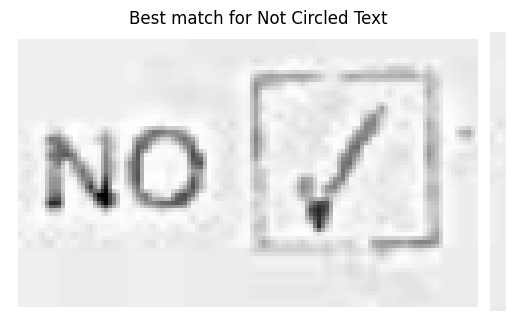

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (126, 62)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x62
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.039207007735967636
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (126, 63)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.1179247796535492
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (126, 62)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x62
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.03911566734313965
DEBUG:main:Resized template 'template_yes_check.PNG' to (126, 64)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x64
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.040803130716085434
DEBUG:main:Resized template 'template_no_check.PNG' to (126, 70)
DEBUG:main:Image size: 126x71


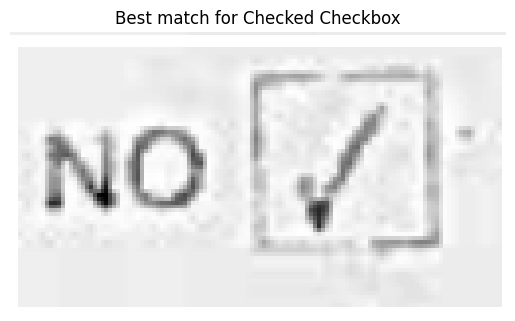

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (126, 63)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.018574779853224754
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (126, 63)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.004677752964198589
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (126, 66)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x66
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.00905098021030426
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (126, 66)
DEBUG:main:Image size: 126x71
DEBUG:main:Template size before resizing: 126x66
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.0129317007958889
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (126, 65)
DEBUG:ma

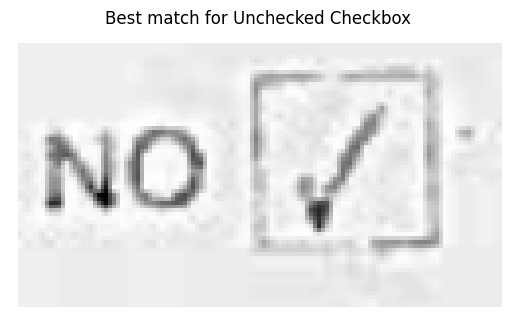

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 59.90636944770813, 'final_result': False, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.90636944770813, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 47.08453714847565, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 43.81678104400635, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_89_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_79.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (146, 75)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x75
DEBUG:main:Template 'template_yes.PNG' match

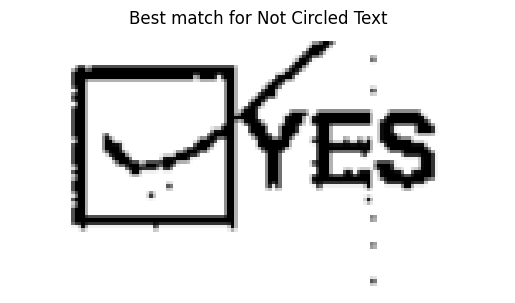

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (146, 72)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.7736449241638184
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.41746559739112854
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (146, 72)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.7110305428504944
DEBUG:main:Resized template 'template_yes_check.PNG' to (146, 74)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x74
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.7371119260787964
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 

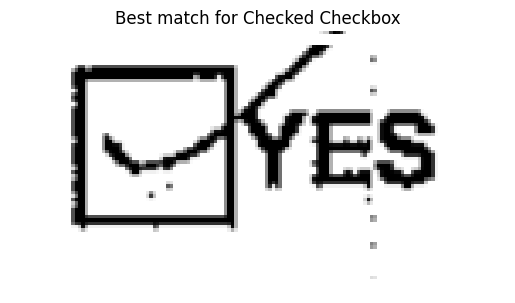

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (146, 73)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.8060562610626221
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.6998497247695923
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.32649660110473633
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (145, 77)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 145x77
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6710252165794373
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (146, 75)
DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 146x75
DEBU

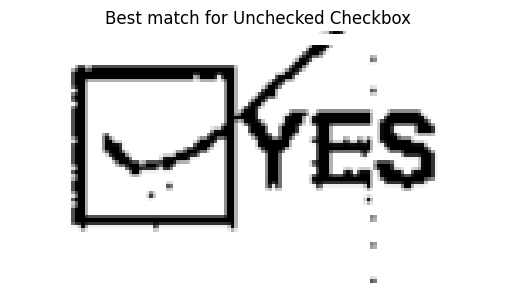

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (45, 18) and radius 24


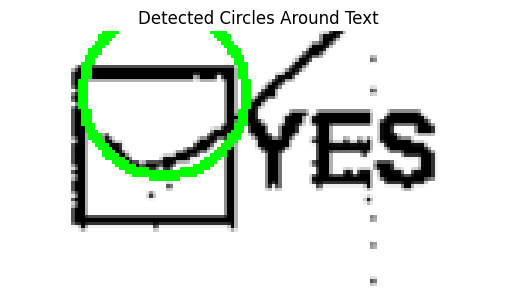

DEBUG:main:Image size: 146x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 146x72
DEBUG:main:Lines detected in checkbox: 25
DEBUG:main:Lines 49 intersect at angle 35.06 degrees with lengths 48.37, 43.19
DEBUG:main:V shape detected with confidence 100.00


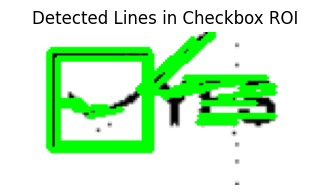

INFO:main:{'confidence': 100, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 55.00982999801636, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 77.36449241638184, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 80.6056261062622, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 100, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_79_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_75.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (132, 68)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x68
DEBUG:main:Template 'template_yes.PNG' match value: -0.06895726919174194
DEBUG:main:Resized template 'temp

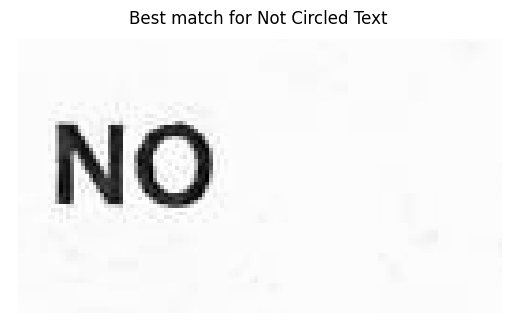

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.07692591100931168
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.17844784259796143
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.08253711462020874
DEBUG:main:Resized template 'template_yes_check.PNG' to (132, 67)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07458732277154922
DEBUG:main:Resized template 'template_no_check.PNG' to (132, 74)
DEBUG:main:Image size: 132x76
D

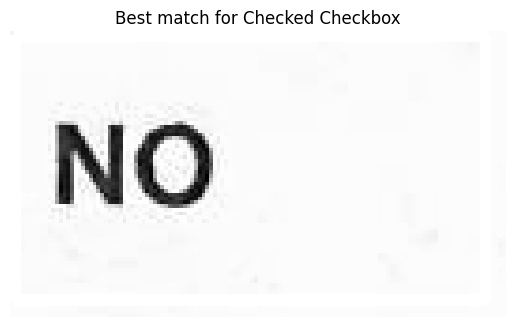

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.049285888671875
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.04300875589251518
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (132, 69)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.05247088894248009
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (132, 70)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04667071998119354
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (132, 68)
DEBUG:ma

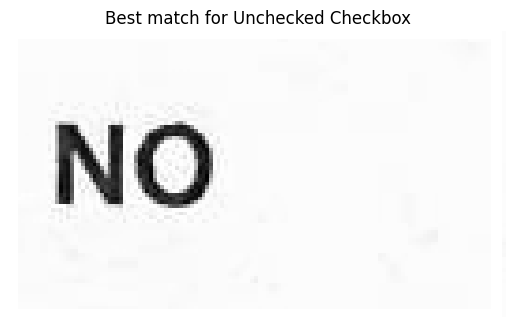

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 132x66
DEBUG:main:Lines detected in checkbox: 2
DEBUG:main:Lines detected but no V or X shape formed.


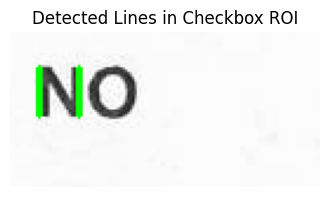

INFO:main:{'confidence': 94.45103406906128, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 94.45103406906128, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 58.58269929885864, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 62.252891063690186, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_75_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_70.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (127, 66)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x66
DEBUG:main:Template 'template_yes.PNG' match value: -0.05265451967716217
DEBUG:main:Resize

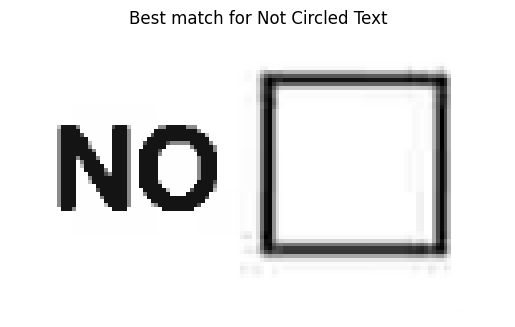

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (127, 63)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x63
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.035356562584638596
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (127, 63)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x63
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.10818252712488174
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (127, 63)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x63
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.045610152184963226
DEBUG:main:Resized template 'template_yes_check.PNG' to (127, 64)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x64
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.0355432853102684
DEBUG:main:Resized template 'template_no_check.PNG' to (127, 71)
DEBUG:main:Image size: 127x73


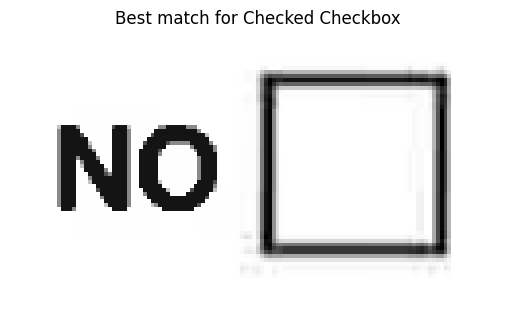

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (127, 63)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x63
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.06801926344633102
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (127, 64)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x64
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.04526275023818016
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (127, 66)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x66
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.05910401791334152
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (127, 67)
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 127x67
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.07155359536409378
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (127, 65)
DEBUG:

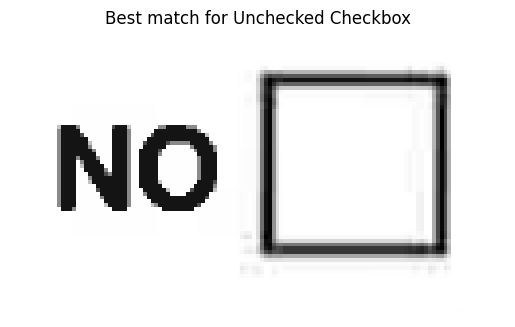

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 127x73
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 127x63
DEBUG:main:Lines detected in checkbox: 12
DEBUG:main:Lines 22 intersect at angle 90.00 degrees with lengths 46.00, 45.00
DEBUG:main:Lines 27 intersect at angle 77.01 degrees with lengths 46.00, 13.34
DEBUG:main:Lines 61 intersect at angle 77.91 degrees with lengths 28.64, 21.00
DEBUG:main:Lines 62 intersect at angle 77.91 degrees with lengths 28.64, 21.00
DEBUG:main:Lines detected but no V or X shape formed.


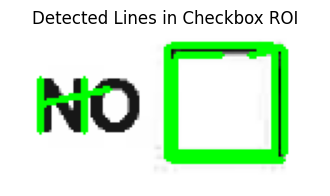

INFO:main:{'confidence': 88.12695145606995, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 64.27626609802246, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 81.49132132530212, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 88.12695145606995, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_70_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_64.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (132, 68)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x68
DEBUG:main:Template 'template_yes.PNG' match value: -0.06627441942691803
DEBUG:main:R

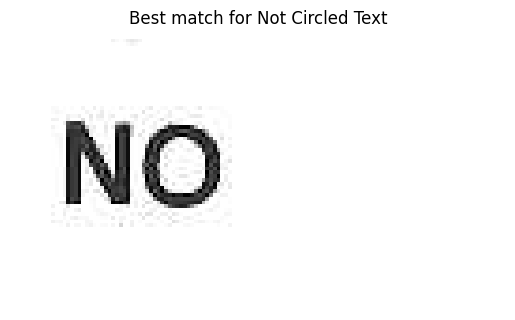

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (132, 65)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.12391620874404907
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.13152512907981873
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (132, 65)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.13504786789417267
DEBUG:main:Resized template 'template_yes_check.PNG' to (132, 67)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.10408873111009598
DEBUG:main:Resized template 'template_no_check.PNG' to (131, 74)
DEBUG:main:Image size: 132x74
D

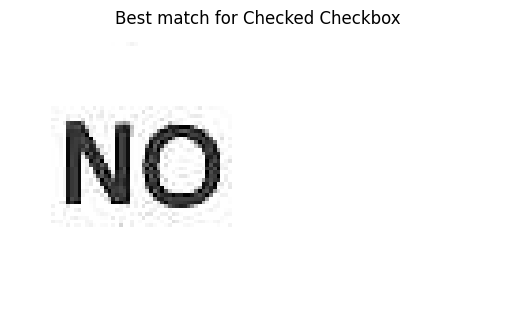

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (132, 66)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.02263929322361946
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.015521099790930748
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (132, 69)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.04954094439744949
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (132, 70)
DEBUG:main:Image size: 132x74
DEBUG:main:Template size before resizing: 132x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.03384032100439072
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (132, 68)
DEBUG:

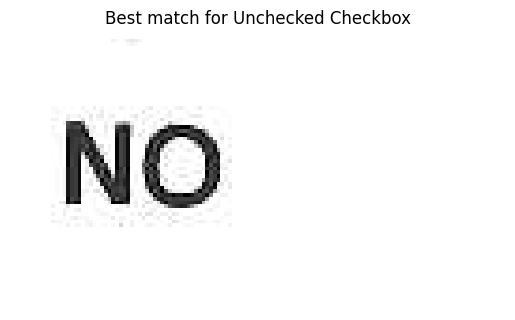

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 86.35010719299316, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 86.35010719299316, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 55.98716139793396, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 58.38753581047058, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_64_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_43.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (147, 76)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x76
DEBUG:main:Template 'template_yes.PNG' match v

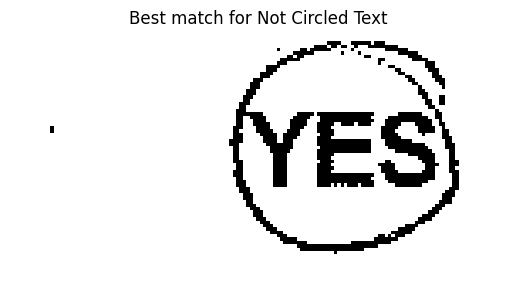

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (147, 73)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x73
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.3498677611351013
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (147, 73)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x73
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.4057227075099945
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (147, 73)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x73
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.24363461136817932
DEBUG:main:Resized template 'template_yes_check.PNG' to (147, 74)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x74
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.328623503446579
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template '

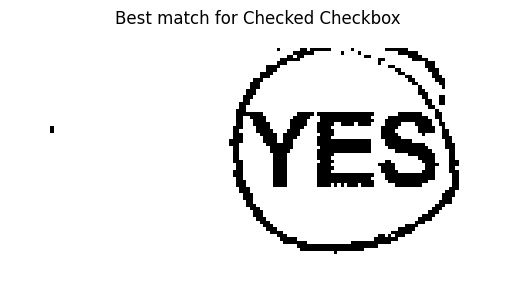

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (147, 73)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x73
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.4456865191459656
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (147, 74)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x74
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.28436967730522156
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.3276250660419464
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x78
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.44585105776786804
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (147, 75)
DEBUG:main:Image size: 147x78
DEBUG:main:Template size before resizing: 147x75
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.315929055

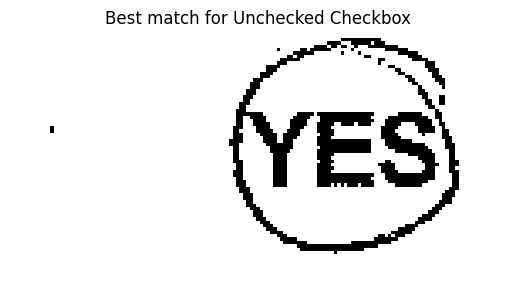

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (99, 35) and radius 30


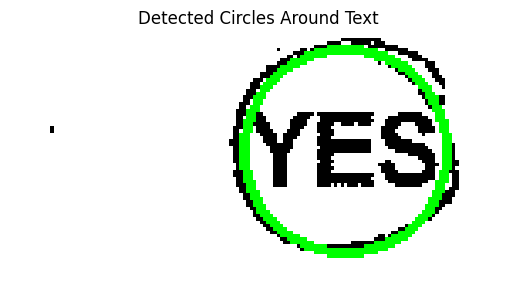

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 66.79834723472595, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 40.57227075099945, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 44.585105776786804, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_43_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_80.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (144, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 144x75
DEBUG:main:Template 'template_yes.PNG' match value: 0.5969459414482117
DEBUG:main:Resized template 'templat

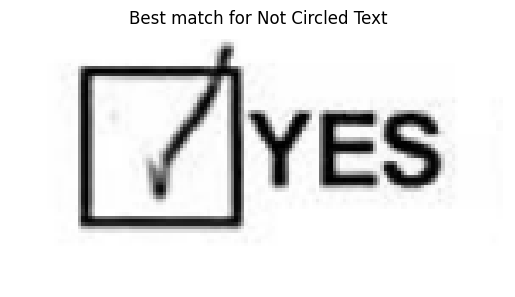

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (146, 72)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.6591046452522278
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.3763869106769562
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (146, 72)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.5007644295692444
DEBUG:main:Resized template 'template_yes_check.PNG' to (146, 74)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x74
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.6237367391586304
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 75)
DEBUG:main:Image size: 146x75
DEBUG

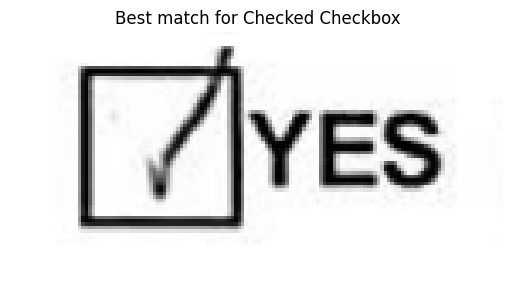

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.7949238419532776
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.4799499213695526
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (142, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 142x75
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.7141318321228027
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (141, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 141x75
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.7457975149154663
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (145, 75)
DEBUG:main:Ima

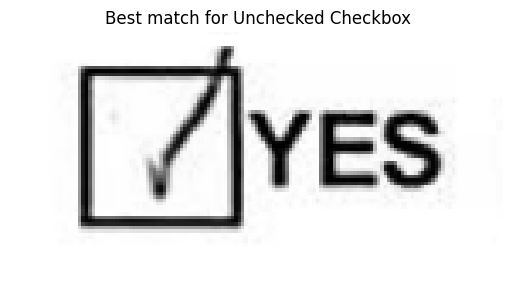

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (101, 12) and radius 33


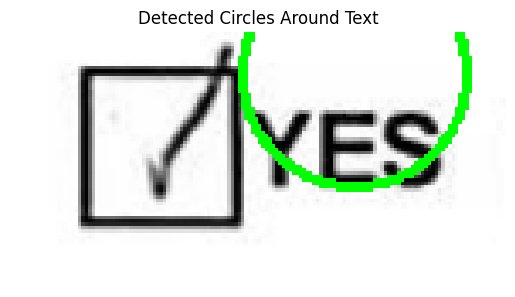

DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 146x72
DEBUG:main:Lines detected in checkbox: 20
DEBUG:main:Lines 20 intersect at angle 90.00 degrees with lengths 48.00, 44.00
DEBUG:main:Lines 38 intersect at angle 90.00 degrees with lengths 21.00, 42.00
DEBUG:main:Lines 53 intersect at angle 55.18 degrees with lengths 21.00, 28.02
DEBUG:main:V shape detected with confidence 86.82


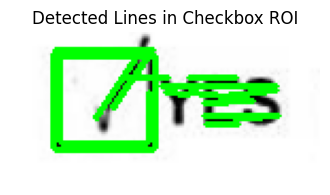

INFO:main:{'confidence': 86.82448915695679, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.69459414482117, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 65.91046452522278, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 79.49238419532776, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 86.82448915695679, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_80_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_2.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (128, 66)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x66
DEBUG:main:Template 'template_yes.PNG' match value: -0.04252060502767563
DEBUG

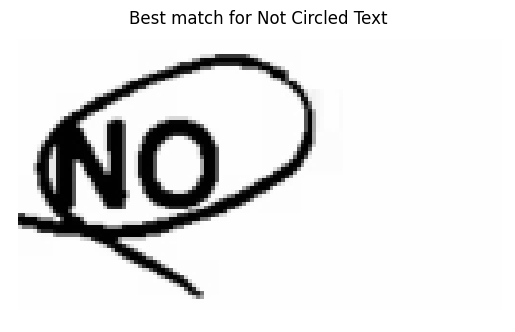

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (128, 63)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x63
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.10892292112112045
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.20681121945381165
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (128, 63)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x63
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.12319184094667435
DEBUG:main:Resized template 'template_yes_check.PNG' to (128, 65)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.10721022635698318
DEBUG:main:Resized template 'template_no_check.PNG' to (128, 72)
DEBUG:main:Image size: 128x75
D

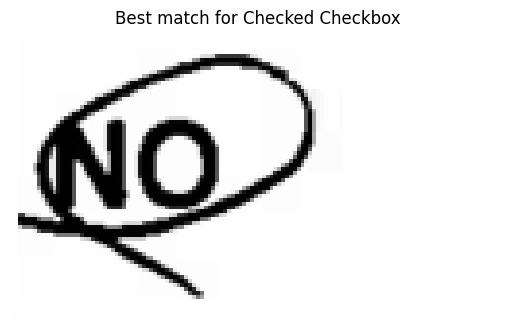

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.02922108955681324
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.06390872597694397
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (128, 67)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x67
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.040721528232097626
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (128, 67)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x67
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.03540744632482529
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (128, 66)
DEBUG:mai

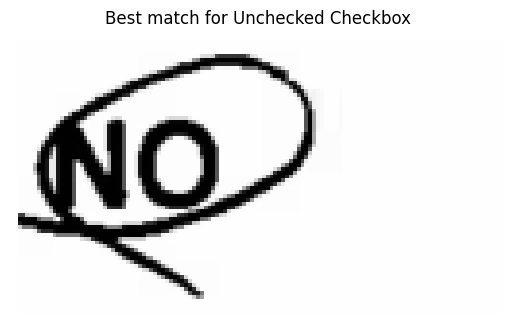

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (54, 34) and radius 28
DEBUG:main:Circles detected with centre at (24, 36) and radius 18


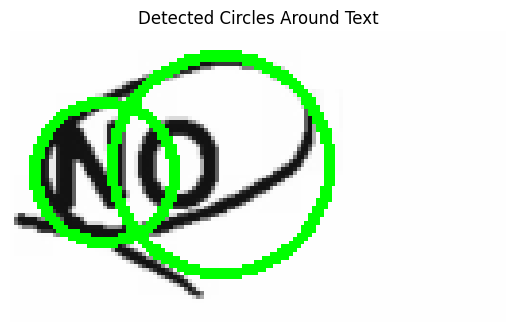

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.06147360801697, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 34.18589234352112, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 39.558619260787964, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_2_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_65.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (136, 70)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x70
DEBUG:main:Template 'template_yes.PNG' match value: -0.03168876841664314
DEBUG:main:Resized template 'templat

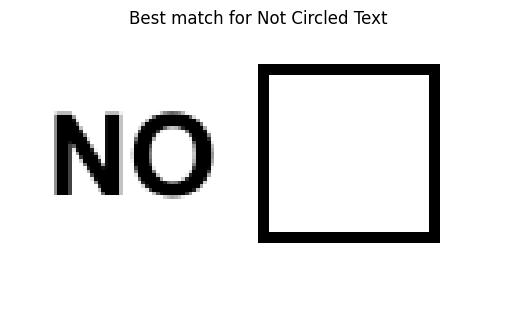

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (136, 67)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.007609202526509762
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.09830858558416367
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (136, 67)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.013153969310224056
DEBUG:main:Resized template 'template_yes_check.PNG' to (136, 69)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x69
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.004895752761512995
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Tem

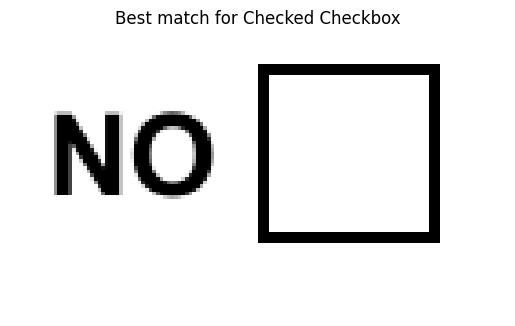

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.05338016897439957
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.06264815479516983
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (136, 71)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.03229910135269165
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (136, 72)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x72
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04326044023036957
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (136, 70)
DEBUG:

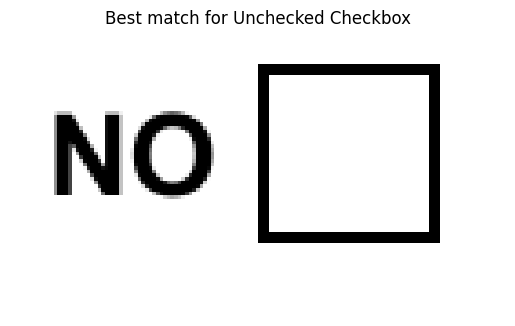

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (96, 36) and radius 21


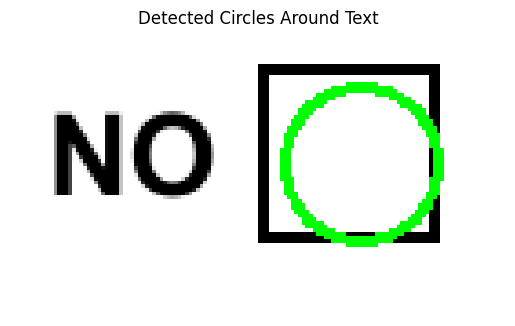

DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 136x67
DEBUG:main:Lines detected in checkbox: 10
DEBUG:main:Lines 3 intersect at angle 90.00 degrees with lengths 50.00, 43.00
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 25 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines detected but no V or X shape formed.


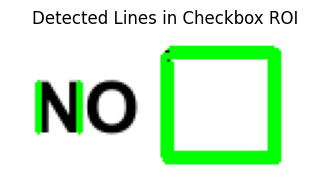

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.78243947029114, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 62.38500475883484, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_65_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_71.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (139, 72)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x72
DEBUG:main:Template 'template_yes.PNG' match value: -0.005324748810380697
DEBUG:main:Resized template 'templ

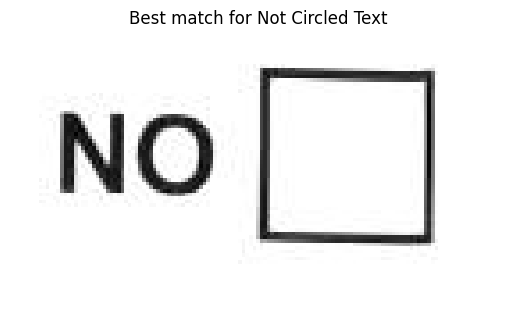

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.047403983771800995
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.12598586082458496
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.04227055236697197
DEBUG:main:Resized template 'template_yes_check.PNG' to (139, 70)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x70
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.0377877876162529
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templa

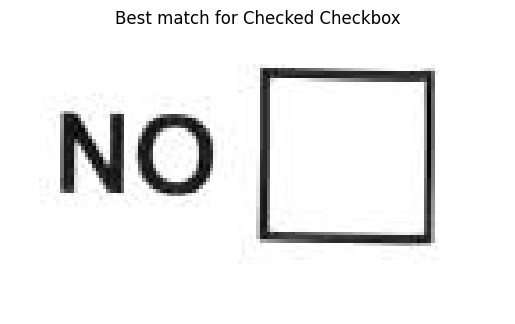

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.029198575764894485
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (139, 70)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x70
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.03701088950037956
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (139, 73)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x73
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.028640536591410637
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (139, 73)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x73
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.027760297060012817
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (139, 71)
DEB

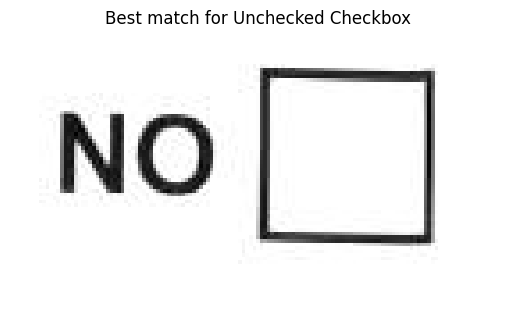

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 139x69
DEBUG:main:Lines detected in checkbox: 11
DEBUG:main:Lines 35 intersect at angle 91.33 degrees with lengths 43.01, 43.00
DEBUG:main:Lines 42 intersect at angle 90.00 degrees with lengths 43.00, 21.00
DEBUG:main:Lines detected but no V or X shape formed.


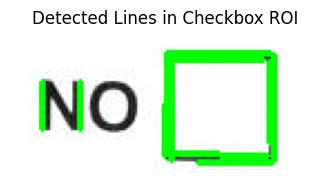

INFO:main:{'confidence': 89.99485373497009, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 57.97185301780701, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 63.047707080841064, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 89.99485373497009, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_71_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_69.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (146, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 146x76
DEBUG:main:Template 'template_yes.PNG' match value: 0.5834232568740845
DEBUG:main:

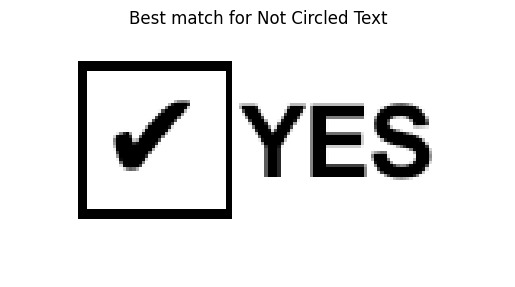

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.9999992251396179
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.44471320509910583
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (152, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.9113848209381104
DEBUG:main:Resized template 'template_yes_check.PNG' to (149, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 149x76
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.7798897624015808
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.11215252429246902
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 125x70


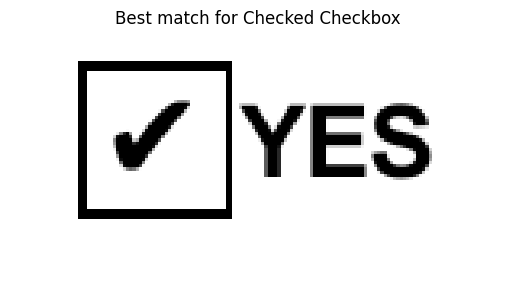

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.9217483401298523
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (150, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 150x76
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.7633859515190125
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (144, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 144x76
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.44329771399497986
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (143, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 143x76
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.5519600510597229
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (147, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 147x76
DE

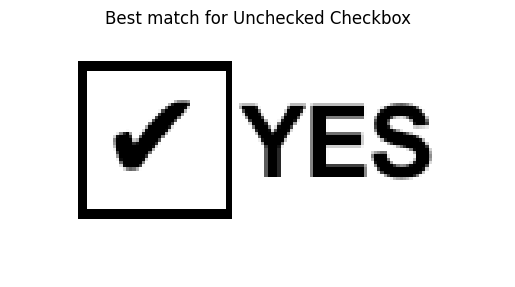

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 29


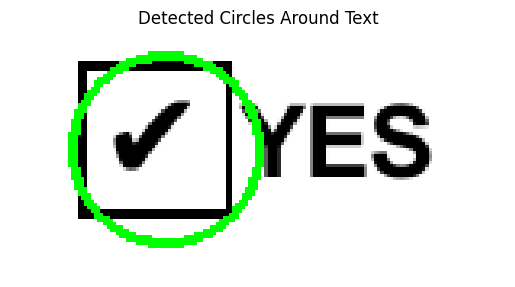

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 15
DEBUG:main:Lines 5 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 8 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 18 intersect at angle 90.91 degrees with lengths 63.01, 43.00
DEBUG:main:Lines 22 intersect at angle 90.91 degrees with lengths 63.01, 41.00
DEBUG:main:Lines 60 intersect at angle 94.67 degrees with lengths 49.16, 43.00
DEBUG:main:Lines 64 intersect at angle 94.67 degrees with lengths 49.16, 41.00
DEBUG:main:Lines detected but no V or X shape formed.


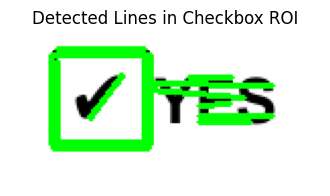

INFO:main:{'confidence': 99.99992251396179, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.34232568740845, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99992251396179, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 92.17483401298523, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_69_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_66.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (132, 68)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x68
DEBUG:main:Template 'template_yes.PNG' match value: -0.06895726919174194
DEBUG:main:R

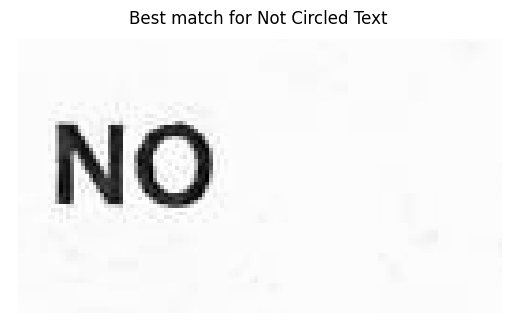

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.07692591100931168
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.17844784259796143
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.08253711462020874
DEBUG:main:Resized template 'template_yes_check.PNG' to (132, 67)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07458732277154922
DEBUG:main:Resized template 'template_no_check.PNG' to (132, 74)
DEBUG:main:Image size: 132x76
D

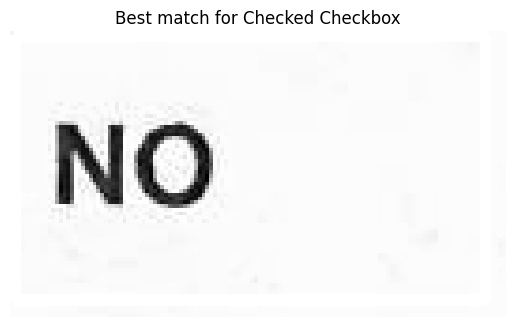

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.049285888671875
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.04300875589251518
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (132, 69)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.05247088894248009
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (132, 70)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04667071998119354
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (132, 68)
DEBUG:ma

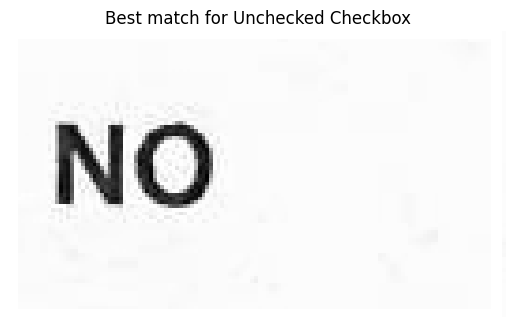

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 132x66
DEBUG:main:Lines detected in checkbox: 2
DEBUG:main:Lines detected but no V or X shape formed.


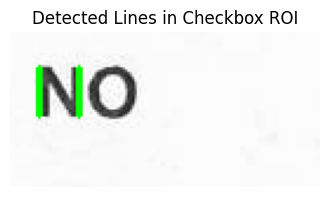

INFO:main:{'confidence': 94.45103406906128, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 94.45103406906128, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 58.58269929885864, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 62.252891063690186, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_66_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_26.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (143, 74)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x74
DEBUG:main:Template 'template_yes.PNG' match value: 0.590582013130188
DEBUG:main:Resized 

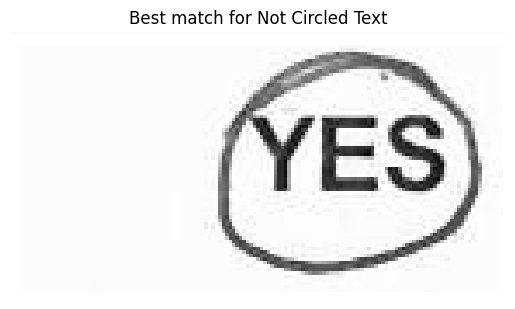

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.25773051381111145
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.32062768936157227
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.17568661272525787
DEBUG:main:Resized template 'template_yes_check.PNG' to (143, 72)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x72
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.23080018162727356
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templa

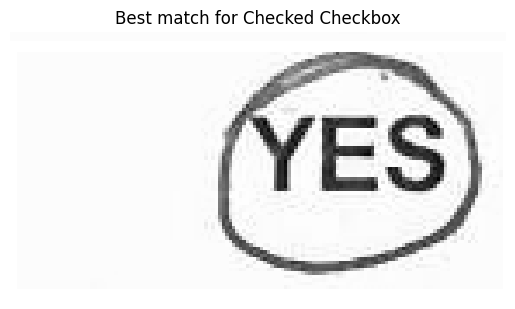

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.34508374333381653
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (143, 72)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x72
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.23270003497600555
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (143, 75)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x75
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.45425552129745483
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (143, 75)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x75
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.4521282911300659
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (143, 73)
DEBUG:main:

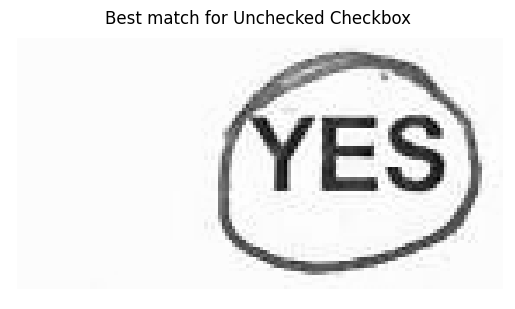

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (97, 45) and radius 35
DEBUG:main:Circles detected with centre at (90, 24) and radius 19


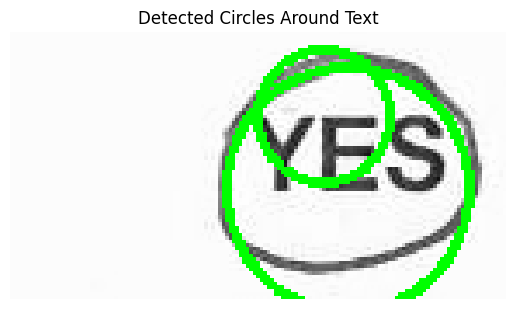

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.0582013130188, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 32.06276893615723, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 45.42555212974548, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_26_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_17.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (139, 72)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x72
DEBUG:main:Template 'template_yes.PNG' match value: -9.080754534807056e-05
DEBUG:main:Resized template 'templ

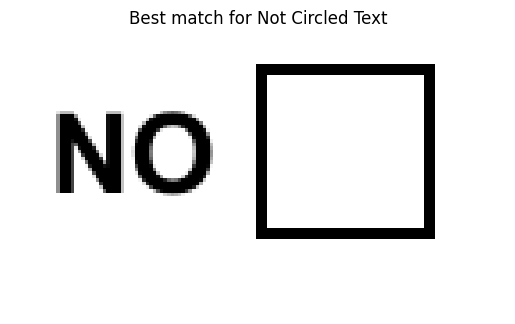

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.031533513218164444
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.12092652171850204
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.022527417168021202
DEBUG:main:Resized template 'template_yes_check.PNG' to (139, 70)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x70
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.02216656506061554
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Temp

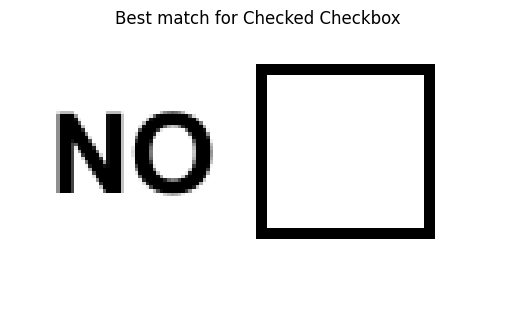

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (139, 69)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x69
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.027417093515396118
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (139, 70)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x70
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.054130539298057556
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (139, 73)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x73
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.02983085811138153
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (139, 73)
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 139x73
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.02803630381822586
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (139, 71)
DEBU

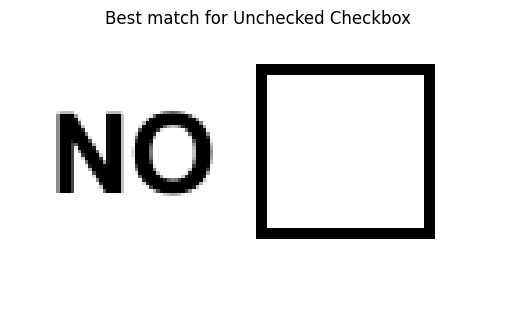

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 139x79
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 139x69
DEBUG:main:Lines detected in checkbox: 10
DEBUG:main:Lines 3 intersect at angle 90.00 degrees with lengths 50.00, 43.00
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 25 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines detected but no V or X shape formed.


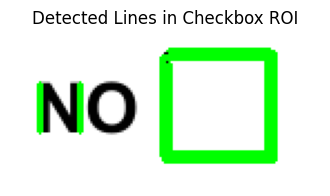

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 51.70588493347168, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 71.54871821403503, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_17_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_34.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (143, 74)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x74
DEBUG:main:Template 'template_yes.PNG' match value: 0.590582013130188
DEBUG:main:Resized template 'template

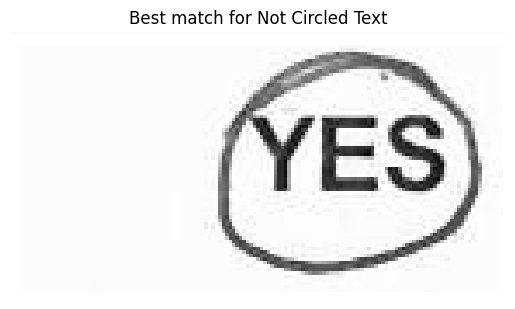

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.25773051381111145
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.32062768936157227
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.17568661272525787
DEBUG:main:Resized template 'template_yes_check.PNG' to (143, 72)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x72
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.23080018162727356
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templa

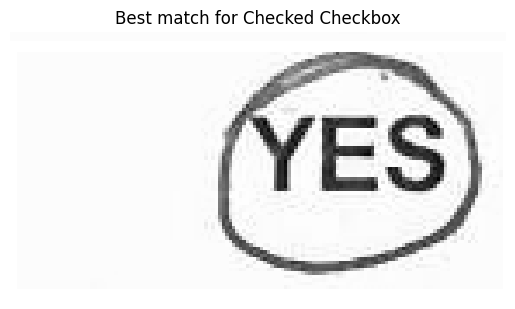

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (143, 71)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x71
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.34508374333381653
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (143, 72)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x72
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.23270003497600555
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (143, 75)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x75
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.45425552129745483
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (143, 75)
DEBUG:main:Image size: 143x77
DEBUG:main:Template size before resizing: 143x75
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.4521282911300659
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (143, 73)
DEBUG:main:

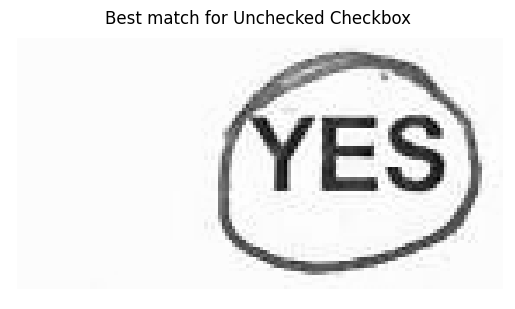

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (97, 45) and radius 35
DEBUG:main:Circles detected with centre at (90, 24) and radius 19


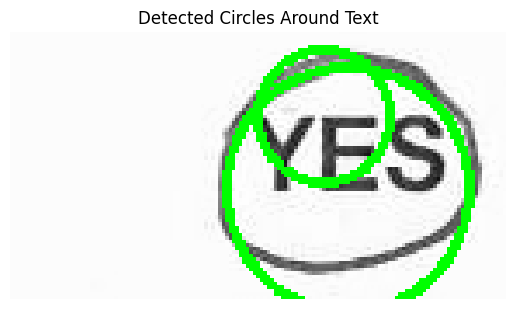

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.0582013130188, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 32.06276893615723, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 45.42555212974548, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_34_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_23.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (137, 71)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x71
DEBUG:main:Template 'template_yes.PNG' match value: 0.3249526023864746
DEBUG:main:Resized template 'template

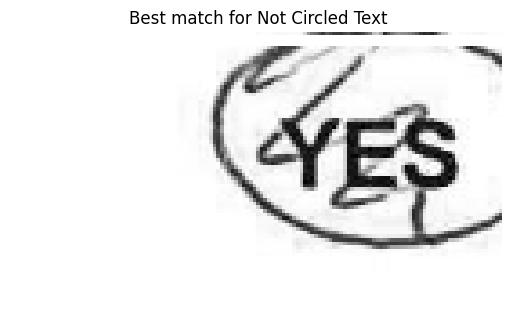

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (137, 68)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x68
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.16218645870685577
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (137, 68)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x68
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.18598057329654694
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (137, 68)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x68
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.1734190285205841
DEBUG:main:Resized template 'template_yes_check.PNG' to (137, 69)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x69
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.16378602385520935
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templat

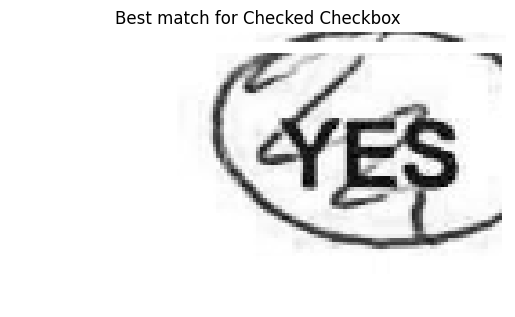

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (137, 68)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x68
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.19377624988555908
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (137, 69)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x69
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.26231953501701355
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (137, 72)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x72
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.19838358461856842
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (137, 72)
DEBUG:main:Image size: 137x76
DEBUG:main:Template size before resizing: 137x72
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.21034829318523407
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (137, 70)
DEBUG:main

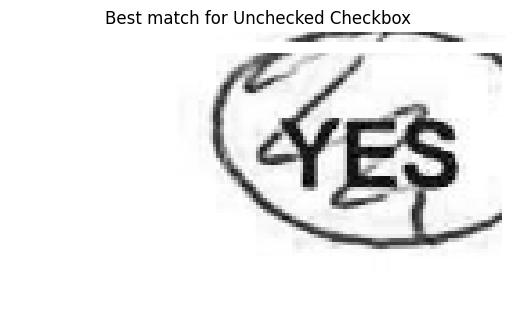

DEBUG:main:Circles detected: 3
DEBUG:main:Circles detected with centre at (85, 28) and radius 27
DEBUG:main:Circles detected with centre at (99, 6) and radius 27
DEBUG:main:Circles detected with centre at (101, 41) and radius 17


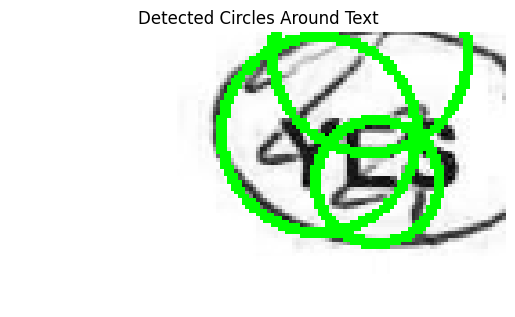

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 32.49526023864746, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 18.598057329654694, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 26.231953501701355, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_23_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_20.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (129, 67)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x67
DEBUG:main:Template 'template_yes.PNG' match value: -0.0276645440608263
DEBUG:main:Resized template 'templ

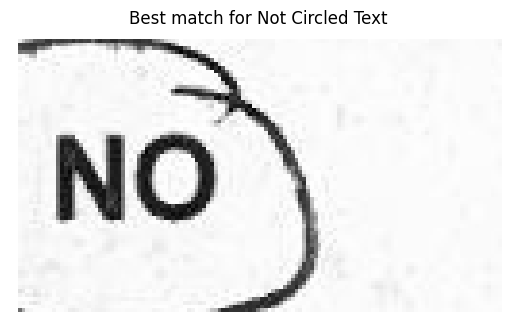

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.09212402999401093
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.16136153042316437
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.09195078909397125
DEBUG:main:Resized template 'template_yes_check.PNG' to (129, 65)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.09686242789030075
DEBUG:main:Resized template 'template_no_check.PNG' to (129, 72)
DEBUG:main:Image size: 129x75
D

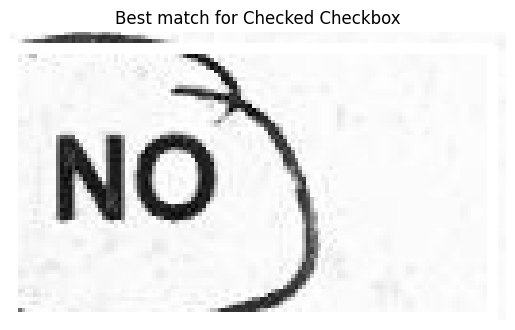

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.07429568469524384
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (129, 65)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.07046210765838623
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (129, 68)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.010159204714000225
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (129, 68)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.03234575688838959
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (129, 66)
DEBUG:ma

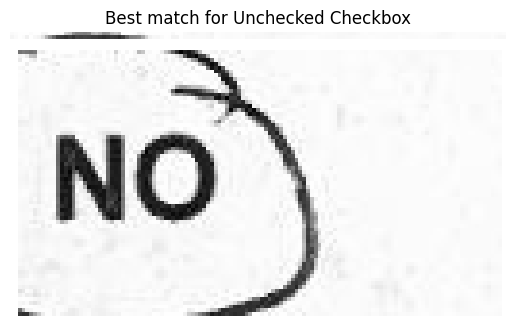

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (45, 45) and radius 27


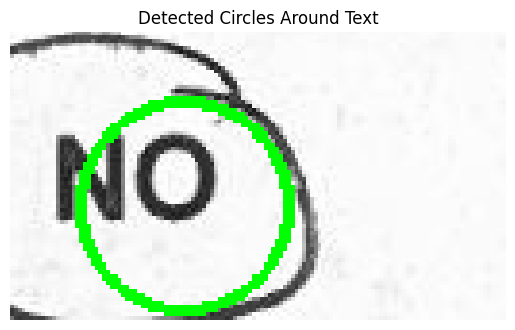

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 68.47818493843079, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 47.44379222393036, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 35.29341220855713, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_20_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_22.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (129, 67)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x67
DEBUG:main:Template 'template_yes.PNG' match value: -0.04557795450091362
DEBUG:main:Resized template 'template

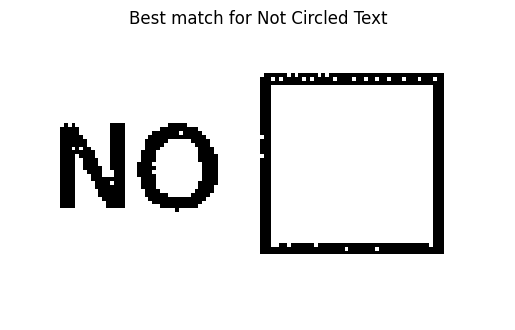

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.018850218504667282
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.09762124717235565
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.02954423613846302
DEBUG:main:Resized template 'template_yes_check.PNG' to (129, 65)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.01900508627295494
DEBUG:main:Resized template 'template_no_check.PNG' to (129, 72)
DEBUG:main:Image size: 129x75


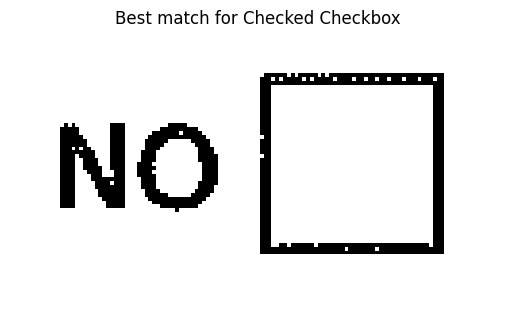

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (129, 64)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.06655193120241165
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (129, 65)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.04788912832736969
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (129, 68)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.036132439970970154
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (129, 68)
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.05551092326641083
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (129, 66)
DEBUG

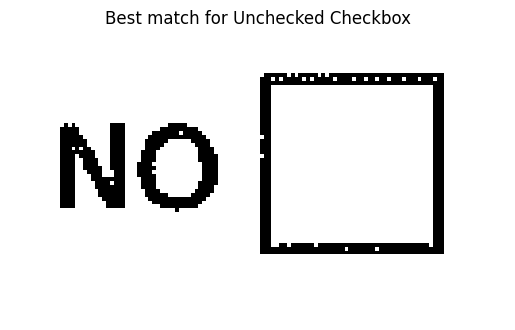

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 129x75
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 129x64
DEBUG:main:Lines detected in checkbox: 13
DEBUG:main:Lines 1 intersect at angle 88.03 degrees with lengths 47.00, 29.02
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 47.00, 37.00
DEBUG:main:Lines 12 intersect at angle 88.03 degrees with lengths 47.00, 29.02
DEBUG:main:Lines 45 intersect at angle 90.00 degrees with lengths 48.00, 13.00
DEBUG:main:Lines 49 intersect at angle 90.00 degrees with lengths 48.00, 23.00
DEBUG:main:Lines 61 intersect at angle 28.10 degrees with lengths 28.16, 39.81
DEBUG:main:V shape detected with confidence 100.00


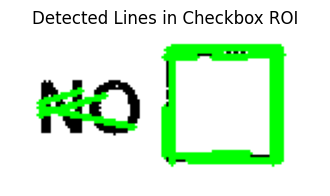

INFO:main:{'confidence': 100, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 56.894707679748535, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 77.24465131759644, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 99.99997615814209, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 100, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_22_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_27.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (135, 70)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x70
DEBUG:main:Template 'template_yes.PNG' match value: -0.03928457945585251
DEBUG:main:Resized template 'tem

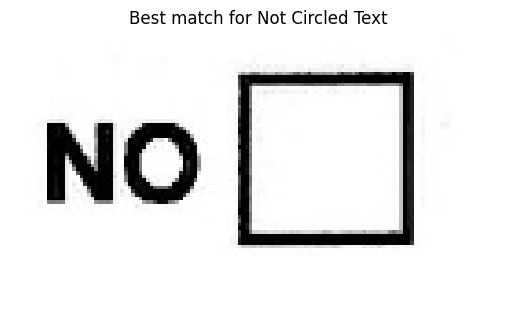

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.0113995261490345
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.056212328374385834
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.023498157039284706
DEBUG:main:Resized template 'template_yes_check.PNG' to (135, 68)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.017141839489340782
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Temp

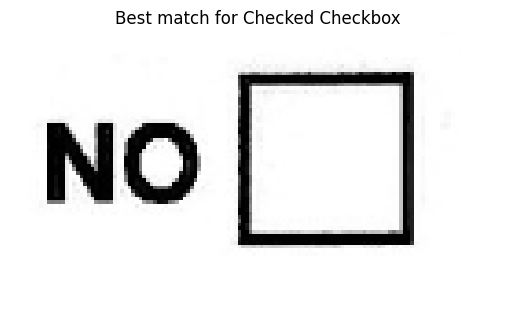

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.060993492603302
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (135, 68)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.05098266527056694
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (135, 71)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.06400246918201447
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (135, 71)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.031105589121580124
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (135, 69)
DEBUG:mai

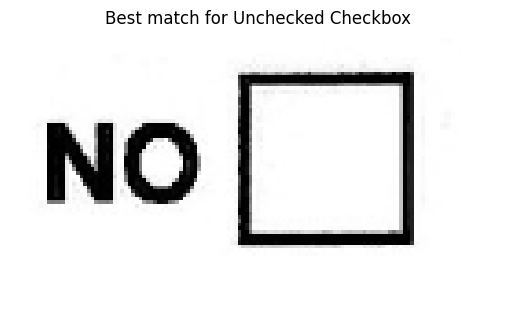

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 135x67
DEBUG:main:Lines detected in checkbox: 8
DEBUG:main:Lines 18 intersect at angle 90.00 degrees with lengths 40.00, 43.00
DEBUG:main:Lines 23 intersect at angle 90.00 degrees with lengths 43.00, 45.00
DEBUG:main:Lines 25 intersect at angle 90.00 degrees with lengths 43.00, 45.00
DEBUG:main:Lines detected but no V or X shape formed.


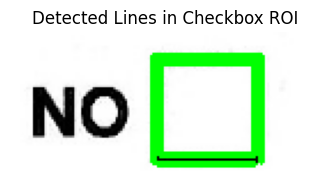

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 47.82979488372803, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 66.41552448272705, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_27_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_25.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (135, 70)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x70
DEBUG:main:Template 'template_yes.PNG' match value: -0.047373346984386444
DEBUG:main:Resized template 'templ

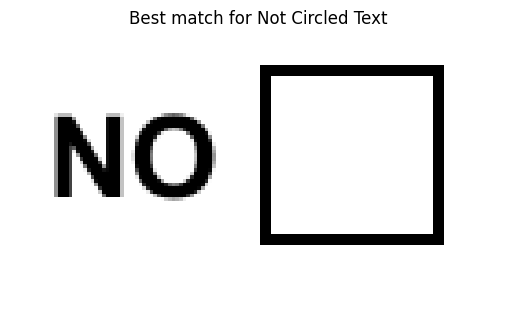

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (135, 67)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.007170943543314934
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (135, 67)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.09041314572095871
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (135, 67)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.017968975007534027
DEBUG:main:Resized template 'template_yes_check.PNG' to (135, 68)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.007563319522887468
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Tem

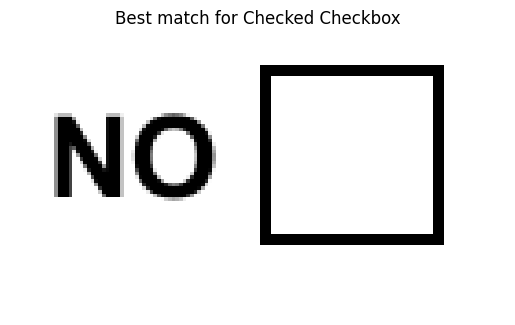

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (135, 67)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.06318709999322891
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (135, 68)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.0684056505560875
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (135, 71)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.039034657180309296
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (135, 71)
DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.05564244091510773
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (135, 69)
DEBUG:

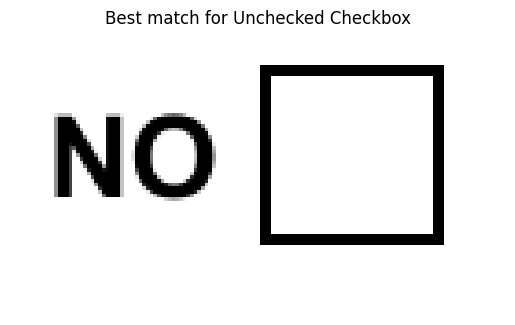

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (96, 36) and radius 21


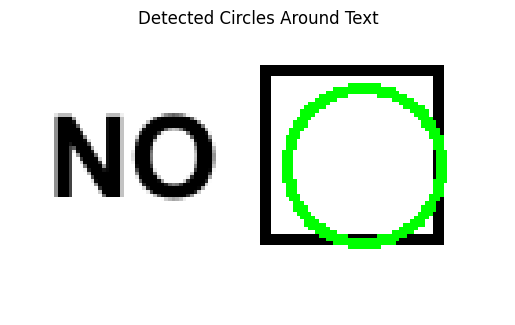

DEBUG:main:Image size: 135x77
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 135x67
DEBUG:main:Lines detected in checkbox: 9
DEBUG:main:Lines detected but no V or X shape formed.


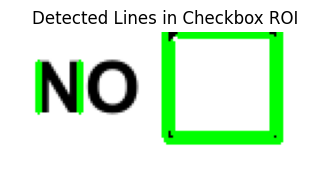

INFO:main:{'confidence': 90.86977243423462, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 57.77563452720642, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 52.5493860244751, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 90.86977243423462, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_25_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_19.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (130, 67)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x67
DEBUG:main:Template 'template_yes.PNG' match value: -0.00829222984611988
DEBUG:main:

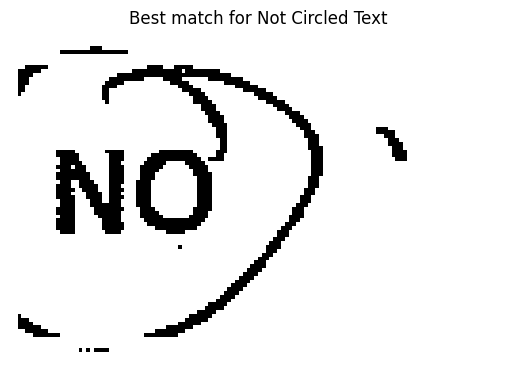

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (130, 64)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x64
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.13439355790615082
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (130, 65)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x65
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.1795291155576706
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (130, 64)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x64
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.1522037535905838
DEBUG:main:Resized template 'template_yes_check.PNG' to (130, 66)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x66
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.13891616463661194
DEBUG:main:Resized template 'template_no_check.PNG' to (130, 73)
DEBUG:main:Image size: 130x85
DEB

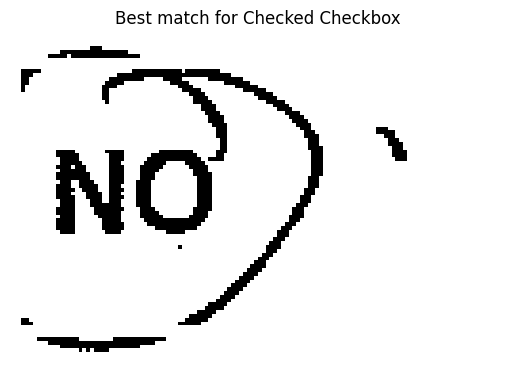

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (130, 65)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x65
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.12263110280036926
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (130, 65)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x65
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.18414302170276642
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (130, 68)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x68
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.10082323104143143
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (130, 68)
DEBUG:main:Image size: 130x85
DEBUG:main:Template size before resizing: 130x68
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.09684368222951889
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (130, 67)
DEBUG:main

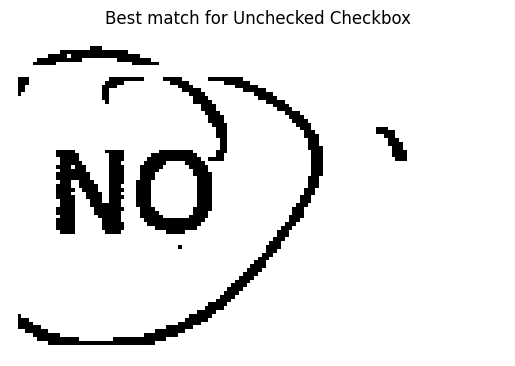

DEBUG:main:Circles detected: 3
DEBUG:main:Circles detected with centre at (24, 41) and radius 38
DEBUG:main:Circles detected with centre at (57, 39) and radius 22
DEBUG:main:Circles detected with centre at (41, 53) and radius 19


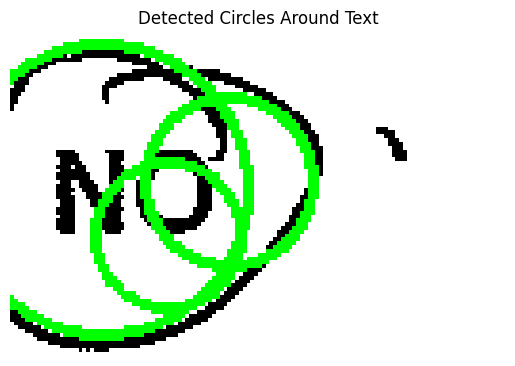

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.40260982513428, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 35.612720251083374, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 34.925100207328796, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_19_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_18.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (136, 70)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x70
DEBUG:main:Template 'template_yes.PNG' match value: -0.03168876841664314
DEBUG:main:Resized template 'templ

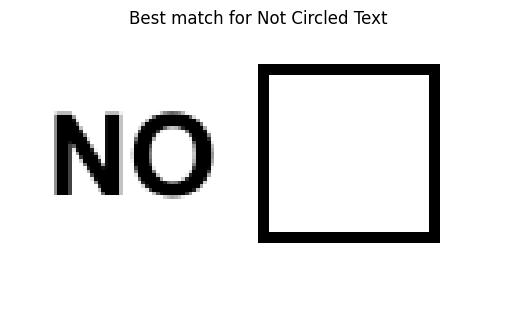

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (136, 67)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.007609202526509762
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.09830858558416367
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (136, 67)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.013153969310224056
DEBUG:main:Resized template 'template_yes_check.PNG' to (136, 69)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x69
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.004895752761512995
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Tem

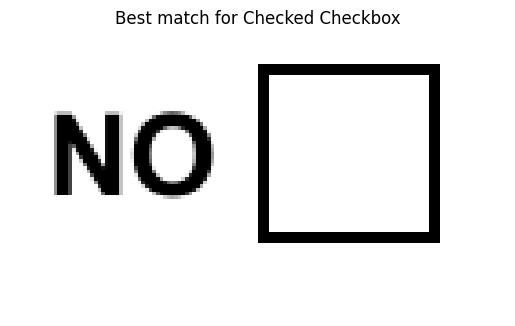

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.05338016897439957
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.06264815479516983
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (136, 71)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.03229910135269165
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (136, 72)
DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 136x72
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04326044023036957
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (136, 70)
DEBUG:

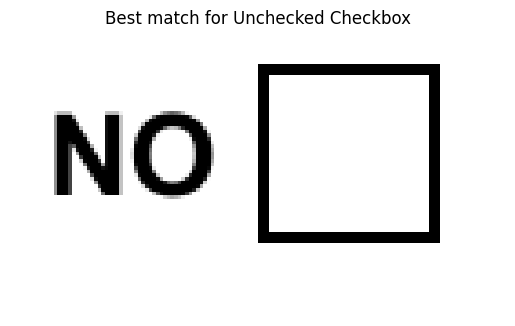

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (96, 36) and radius 21


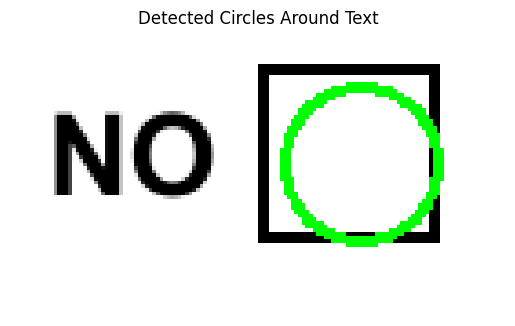

DEBUG:main:Image size: 136x78
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 136x67
DEBUG:main:Lines detected in checkbox: 10
DEBUG:main:Lines 3 intersect at angle 90.00 degrees with lengths 50.00, 43.00
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 25 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines detected but no V or X shape formed.


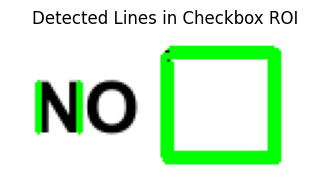

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.78243947029114, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 62.38500475883484, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_18_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_70.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (144, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 144x75
DEBUG:main:Template 'template_yes.PNG' match value: 0.46191948652267456
DEBUG:main:Resized template 'templa

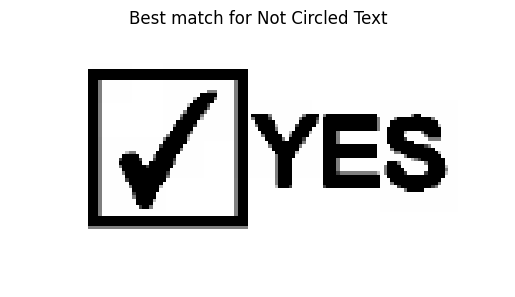

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (146, 72)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.4392774999141693
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.2394578754901886
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (146, 72)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x72
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.374850332736969
DEBUG:main:Resized template 'template_yes_check.PNG' to (146, 74)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x74
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.3886457681655884
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 75)
DEBUG:main:Image size: 146x75
DEBUG:

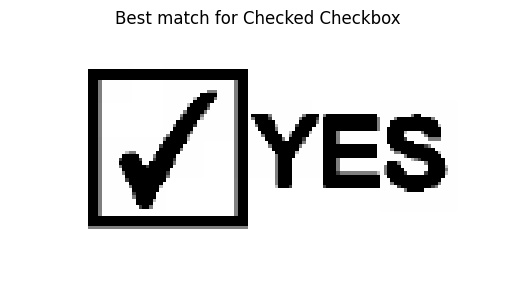

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.477119117975235
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (146, 73)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 146x73
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.3699992299079895
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (142, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 142x75
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.7936395406723022
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (141, 75)
DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 141x75
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6881421208381653
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (145, 75)
DEBUG:main:Imag

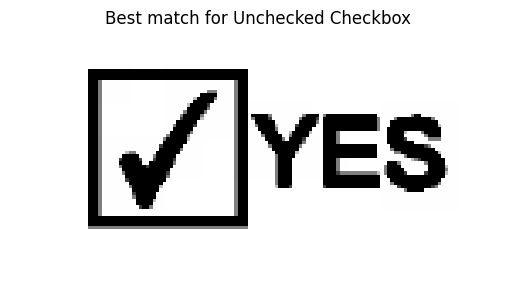

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (48, 36) and radius 26
DEBUG:main:Circles detected with centre at (102, 12) and radius 28


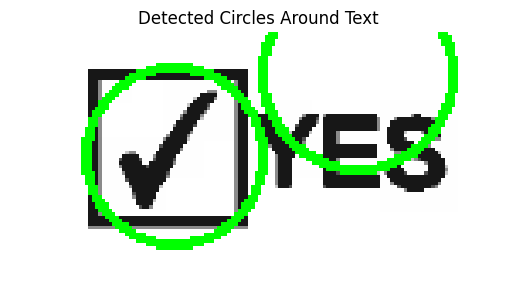

DEBUG:main:Image size: 146x75
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 146x73
DEBUG:main:Lines detected in checkbox: 18
DEBUG:main:Lines 0 intersect at angle 90.00 degrees with lengths 47.00, 46.00
DEBUG:main:Lines 2 intersect at angle 88.67 degrees with lengths 47.00, 43.01
DEBUG:main:Lines 3 intersect at angle 90.00 degrees with lengths 47.00, 42.00
DEBUG:main:Lines 49 intersect at angle 88.67 degrees with lengths 43.01, 45.00
DEBUG:main:Lines 88 intersect at angle 58.01 degrees with lengths 41.68, 33.02
DEBUG:main:V shape detected with confidence 100.00


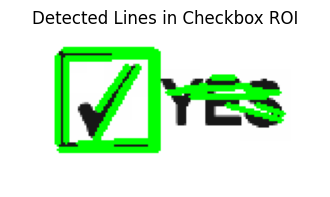

INFO:main:{'confidence': 100, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 46.191948652267456, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 43.92774999141693, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 79.36395406723022, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 100, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_70_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no3.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (132, 68)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x68
DEBUG:main:Template 'template_yes.PNG' match value: -0.06071767210960388
DEBUG:main:Resized template 'temp

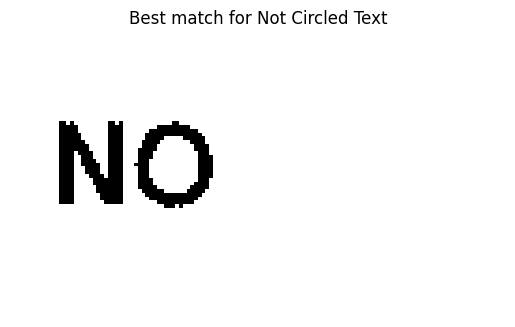

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.06766145676374435
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.17557531595230103
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.0740148201584816
DEBUG:main:Resized template 'template_yes_check.PNG' to (132, 67)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.06534292548894882
DEBUG:main:Resized template 'template_no_check.PNG' to (132, 74)
DEBUG:main:Image size: 132x76
DE

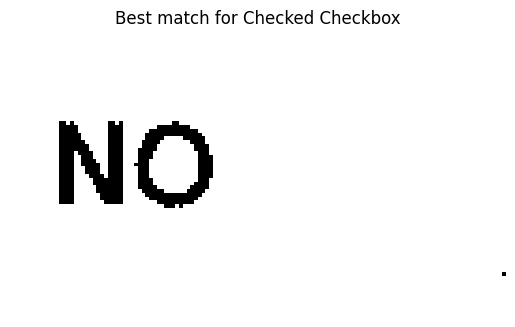

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.04793067276477814
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.03796399012207985
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (132, 69)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.050640009343624115
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (132, 70)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04470252990722656
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (132, 68)
DEBUG

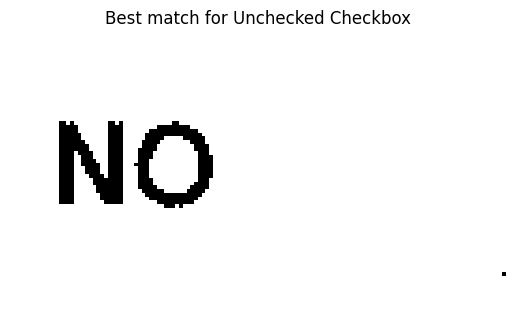

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 132x66
DEBUG:main:Lines detected in checkbox: 1
DEBUG:main:Lines detected but no V or X shape formed.


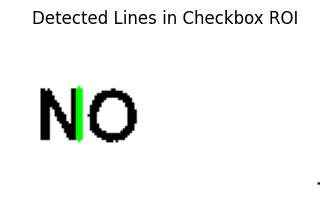

INFO:main:{'confidence': 99.99980926513672, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 99.99980926513672, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 56.655681133270264, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 63.63154053688049, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no3_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no2.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (133, 69)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x69
DEBUG:main:Template 'template_yes.PNG' match value: -0.06074335798621178
DEBUG:main:Resized temp

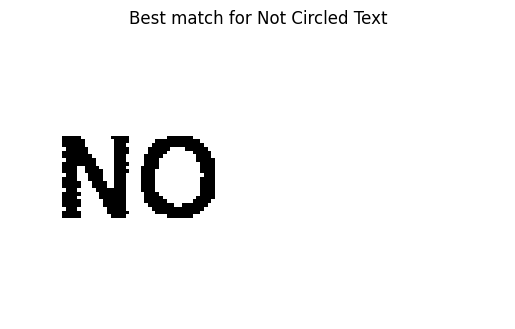

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.09569158405065536
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.13780535757541656
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.10466790199279785
DEBUG:main:Resized template 'template_yes_check.PNG' to (133, 67)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.08294198662042618
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 74)
DEBUG:main:Image size: 133x77
D

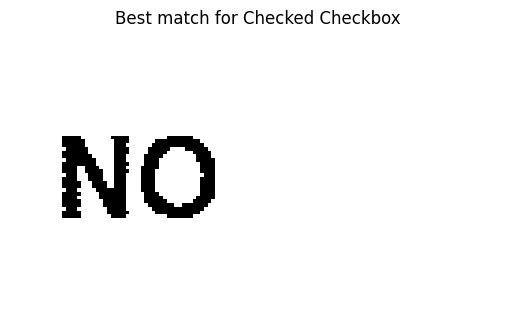

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.024351803585886955
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (133, 67)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x67
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.07282708585262299
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (133, 70)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x70
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.049844395369291306
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (133, 70)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.013891943730413914
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (133, 68)
DEBUG

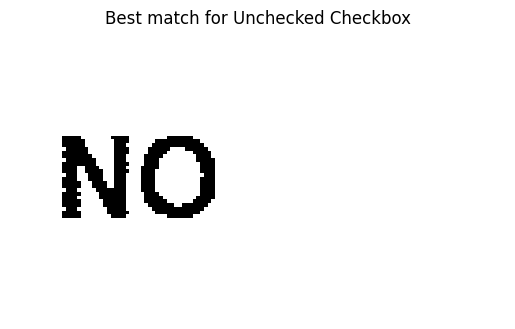

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 90.7500684261322, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 90.7500684261322, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 55.72093725204468, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 51.630568504333496, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no2_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_65.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (148, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 148x77
DEBUG:main:Template 'template_yes.PNG' match value

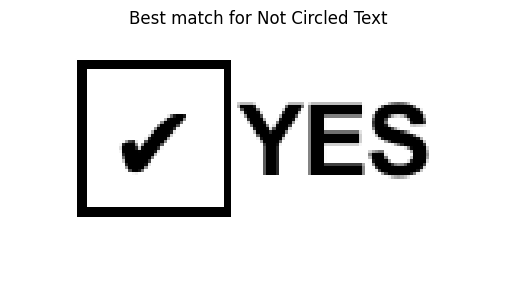

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.94220370054245
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.4250476360321045
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.9423990845680237
DEBUG:main:Resized template 'template_yes_check.PNG' to (151, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 151x77
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.8453245162963867
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.11969812214374542
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.1591240465

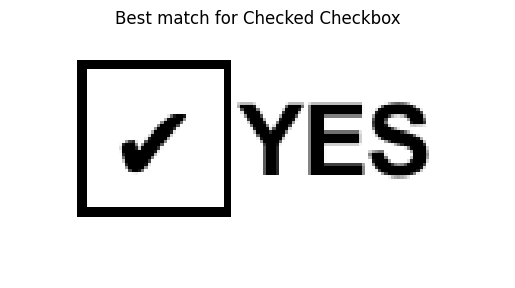

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.941005527973175
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (152, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 152x77
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.8266893029212952
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.45210519433021545
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (145, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 145x77
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6200582981109619
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (149, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 149x77
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.330423653

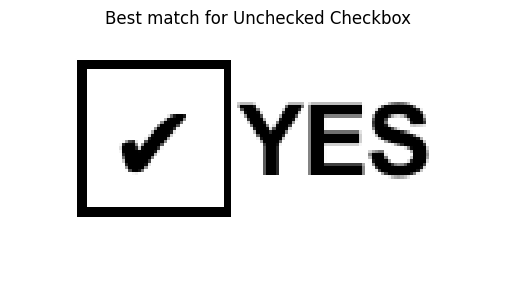

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 29


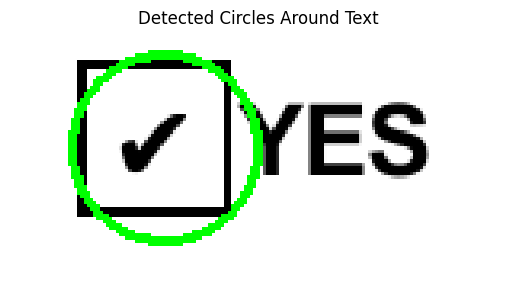

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 18
DEBUG:main:Lines 1 intersect at angle 90.00 degrees with lengths 49.00, 49.00
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 49.00, 47.00
DEBUG:main:Lines 17 intersect at angle 90.00 degrees with lengths 49.00, 49.00
DEBUG:main:Lines 20 intersect at angle 90.00 degrees with lengths 49.00, 47.00
DEBUG:main:Lines 33 intersect at angle 90.00 degrees with lengths 49.00, 44.00
DEBUG:main:Lines 36 intersect at angle 90.00 degrees with lengths 49.00, 44.00
DEBUG:main:Lines detected but no V or X shape formed.


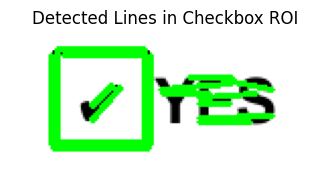

INFO:main:{'confidence': 94.23990845680237, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.86879563331604, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 94.23990845680237, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 94.1005527973175, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_65_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_71.PNG
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 150x78
DEBUG:main:Template 'template_yes.PNG' match value: 0.5611326098442078
DEBUG:main:Resized template 'template_yes_2.PNG' to (161, 81)
DEBUG:main:I

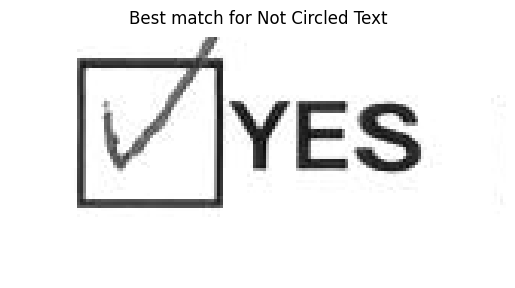

DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.8581121563911438
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.5317144989967346
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.8586236834526062
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 155x79
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.7960747480392456
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.12338906526565552
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.15297019481658936
DEBUG:main:Image size: 163x81
DEBUG:main:Template size b

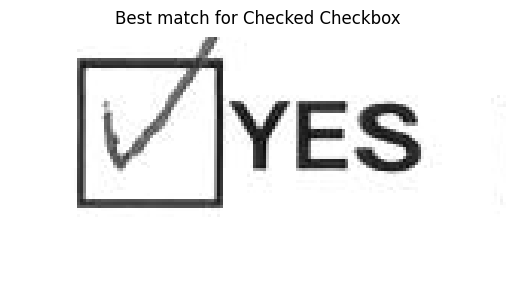

DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.8650243282318115
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (160, 80)
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 160x80
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.6802034974098206
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.4865078628063202
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 147x78
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6574318408966064
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 151x78
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.34274452924728394
DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 136x77
DEBUG:main:Template 'template_no_uncheck.PNG' match 

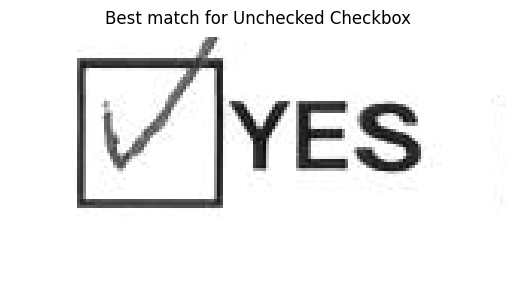

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (48, 34) and radius 24
DEBUG:main:Circles detected with centre at (30, 12) and radius 27


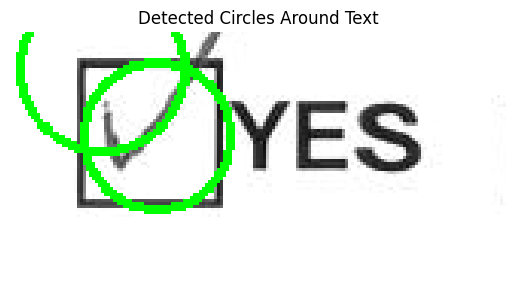

DEBUG:main:Image size: 163x81
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 23
DEBUG:main:Lines 26 intersect at angle 90.00 degrees with lengths 54.00, 47.00
DEBUG:main:Lines 27 intersect at angle 90.00 degrees with lengths 54.00, 47.00
DEBUG:main:Lines 43 intersect at angle 90.00 degrees with lengths 48.00, 39.00
DEBUG:main:Lines 45 intersect at angle 90.00 degrees with lengths 48.00, 44.00
DEBUG:main:Lines 46 intersect at angle 90.00 degrees with lengths 48.00, 47.00
DEBUG:main:Lines 47 intersect at angle 90.00 degrees with lengths 48.00, 47.00
DEBUG:main:Lines 108 intersect at angle 53.97 degrees with lengths 44.00, 40.80
DEBUG:main:V shape detected with confidence 100.00


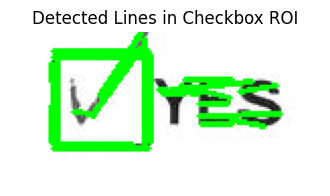

INFO:main:{'confidence': 100, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 56.113260984420776, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 85.86236834526062, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 86.50243282318115, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 100, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_71_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_59.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (148, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 148x77
DEBUG:main:Template 'template_yes.PNG' match value: 0.5758856534957886
DEBUG:main:Resized template 'tem

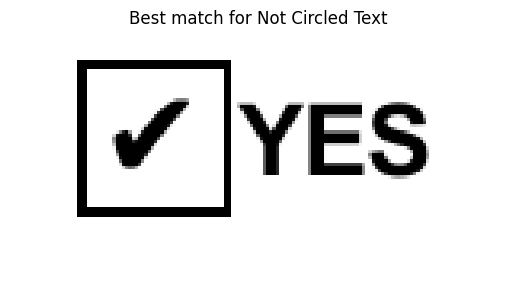

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.9999992251396179
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.4447122812271118
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.9999994039535522
DEBUG:main:Resized template 'template_yes_check.PNG' to (151, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 151x77
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.8780152797698975
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.11215298622846603
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.15424308

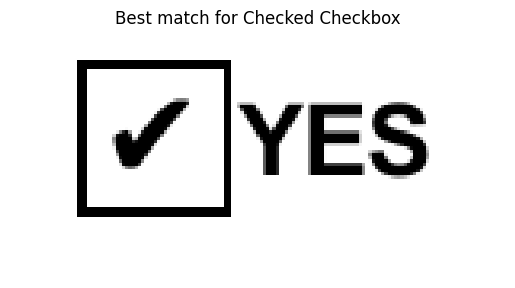

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.9217483401298523
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (152, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 152x77
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.8083197474479675
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.44038793444633484
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (145, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 145x77
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6050483584403992
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (149, 77)
DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 149x77
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.32049614

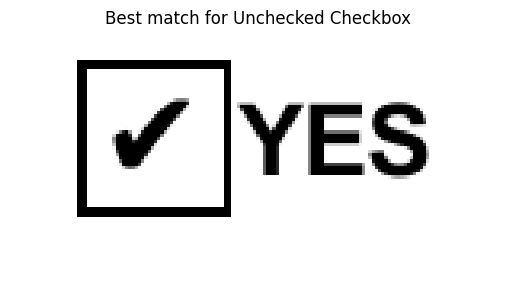

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 29


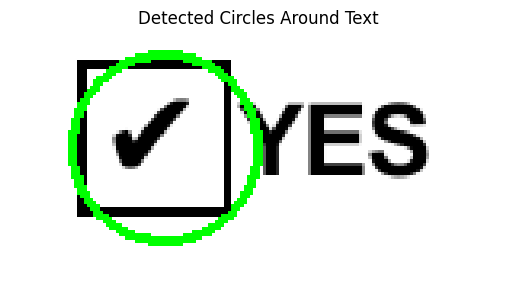

DEBUG:main:Image size: 155x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 15
DEBUG:main:Lines 5 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 8 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 18 intersect at angle 90.91 degrees with lengths 63.01, 43.00
DEBUG:main:Lines 22 intersect at angle 90.91 degrees with lengths 63.01, 41.00
DEBUG:main:Lines 60 intersect at angle 94.67 degrees with lengths 49.16, 43.00
DEBUG:main:Lines 64 intersect at angle 94.67 degrees with lengths 49.16, 41.00
DEBUG:main:Lines detected but no V or X shape formed.


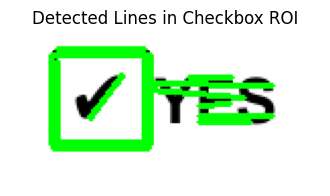

INFO:main:{'confidence': 99.99994039535522, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 57.58856534957886, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99994039535522, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 92.17483401298523, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_59_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_97.PNG
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 150x78
DEBUG:main:Template 'template_yes.PNG' match value: 0.24539324641227722
DEBUG:main:Resized template 'template_yes_2.PNG' to (285, 142)
DEBUG:mai

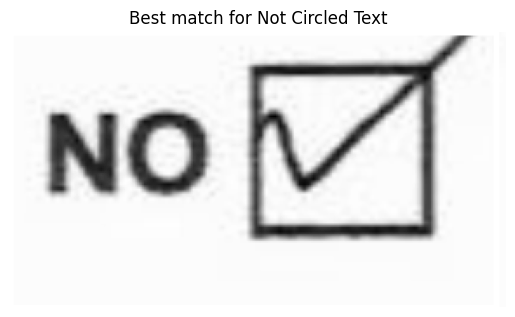

DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.2629273533821106
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.2680460512638092
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.26585111021995544
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 155x79
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.26007571816444397
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.24717459082603455
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.3005582392215729
DEBUG:main:Image size: 285x158
DEBUG:main:Templat

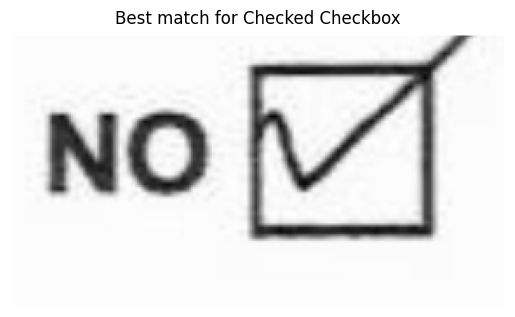

DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.23742391169071198
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (285, 143)
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 285x143
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.013249042443931103
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.23514480888843536
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 147x78
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.2717258632183075
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 151x78
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.2241404503583908
DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 136x77
DEBUG:main:Template 'template_no_uncheck

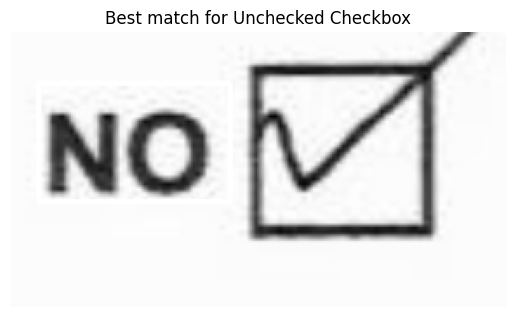

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (90, 69) and radius 23


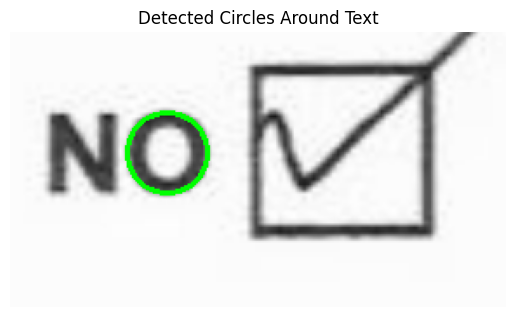

DEBUG:main:Image size: 285x158
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 10
DEBUG:main:Lines 29 intersect at angle 90.22 degrees with lengths 30.02, 34.01
DEBUG:main:Lines detected but no V or X shape formed.


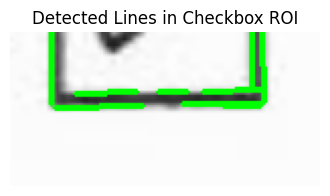

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 53.59839200973511, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 38.07148635387421, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_97_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_73.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (146, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 146x76
DEBUG:main:Template 'template_yes.PNG' match value: 0.5834232568740845
DEBUG:main:Resized template 'template

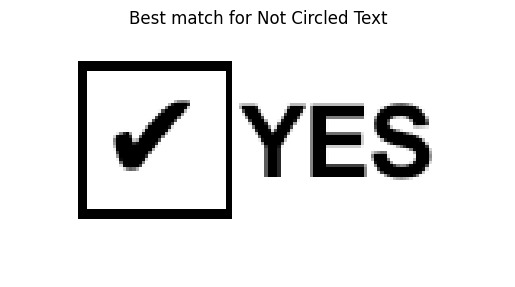

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.9999992251396179
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.44471320509910583
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (152, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.9113848209381104
DEBUG:main:Resized template 'template_yes_check.PNG' to (149, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 149x76
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.7798897624015808
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.11215252429246902
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 125x70


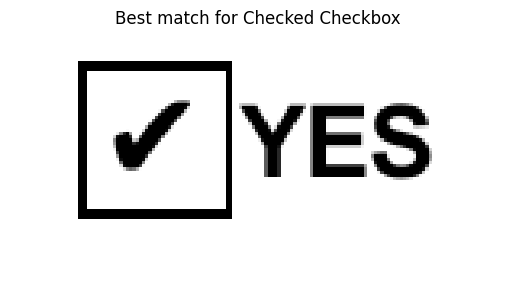

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.9217483401298523
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (150, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 150x76
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.7633859515190125
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (144, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 144x76
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.44329771399497986
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (143, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 143x76
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.5519600510597229
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (147, 76)
DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 147x76
DE

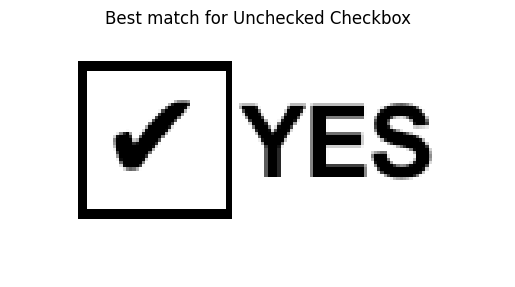

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 29


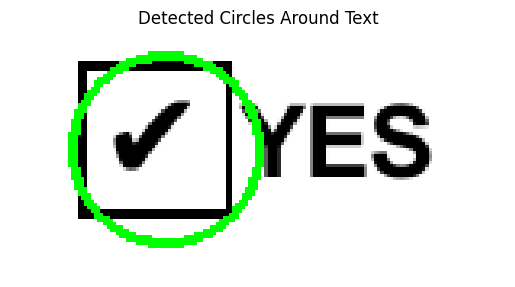

DEBUG:main:Image size: 154x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 15
DEBUG:main:Lines 5 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 8 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 18 intersect at angle 90.91 degrees with lengths 63.01, 43.00
DEBUG:main:Lines 22 intersect at angle 90.91 degrees with lengths 63.01, 41.00
DEBUG:main:Lines 60 intersect at angle 94.67 degrees with lengths 49.16, 43.00
DEBUG:main:Lines 64 intersect at angle 94.67 degrees with lengths 49.16, 41.00
DEBUG:main:Lines detected but no V or X shape formed.


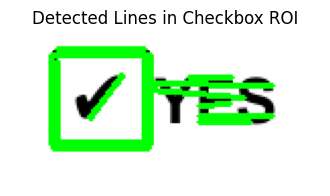

INFO:main:{'confidence': 99.99992251396179, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.34232568740845, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99992251396179, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 92.17483401298523, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_73_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (129, 67)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x67
DEBUG:main:Template 'template_yes.PNG' match value: -0.06603830307722092
DEBUG:main:Resi

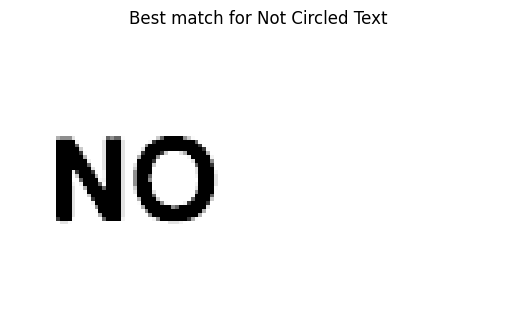

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (129, 64)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.0670749768614769
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (129, 64)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.1582697480916977
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (129, 64)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.07373146712779999
DEBUG:main:Resized template 'template_yes_check.PNG' to (129, 65)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07566419988870621
DEBUG:main:Resized template 'template_no_check.PNG' to (127, 72)
DEBUG:main:Image size: 129x72
DEB

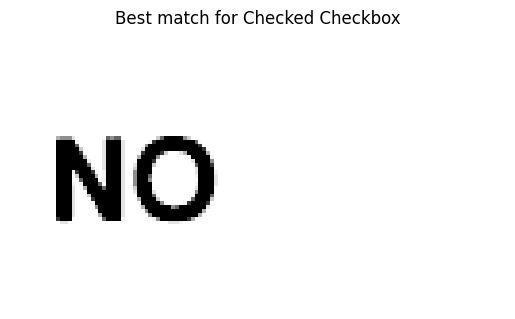

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (129, 64)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.033130429685115814
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (129, 65)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.04676172882318497
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (129, 68)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.04561114311218262
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (129, 68)
DEBUG:main:Image size: 129x72
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.00917096994817257
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (129, 66)
DEBUG:m

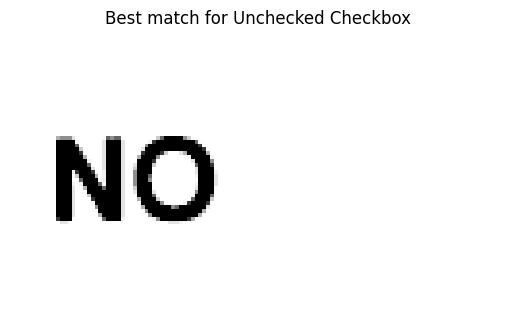

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 84.29566025733948, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 84.29566025733948, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 50.15985369682312, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 41.83128774166107, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_72.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (141, 73)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x73
DEBUG:main:Template 'template_yes.PNG' match valu

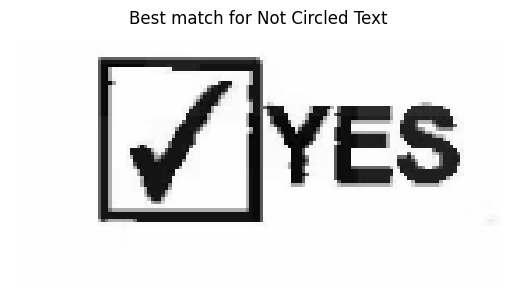

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (141, 70)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x70
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.29534387588500977
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (141, 70)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x70
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.2122601568698883
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (141, 70)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x70
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.2771095335483551
DEBUG:main:Resized template 'template_yes_check.PNG' to (141, 71)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x71
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.26535239815711975
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 75)
DEBUG:main:Image size: 141x75
DEB

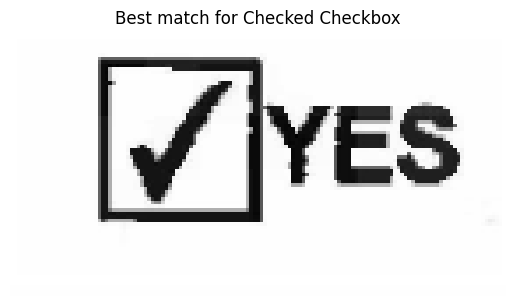

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (141, 70)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x70
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.3074913024902344
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (141, 71)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x71
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.30466917157173157
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (141, 74)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x74
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.1040559783577919
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (141, 74)
DEBUG:main:Image size: 141x75
DEBUG:main:Template size before resizing: 141x74
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.21757805347442627
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (141, 72)
DEBUG:main:I

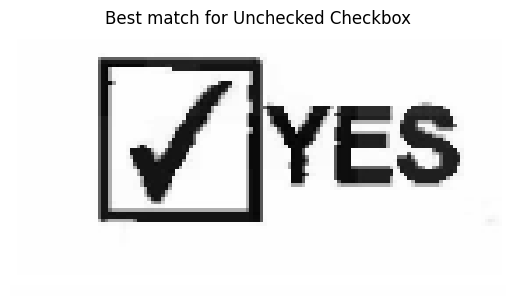

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (54, 35) and radius 17


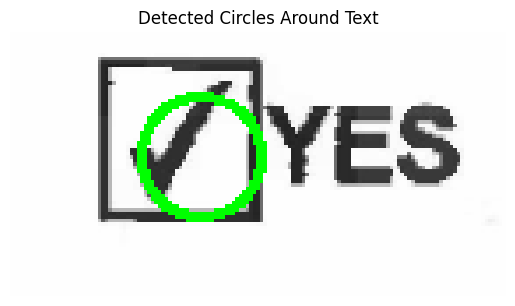

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 22.803305089473724, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 29.534387588500977, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 30.749130249023438, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_72_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_69.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (136, 70)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x70
DEBUG:main:Template 'template_yes.PNG' match value: -0.03168703615665436
DEBUG:main:Resized template 'tem

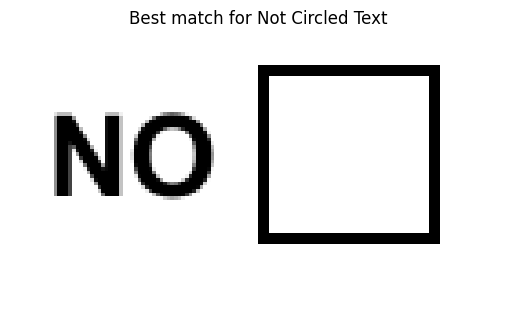

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (136, 67)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.0076074143871665
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.09830743074417114
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (136, 67)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.013153969310224056
DEBUG:main:Resized template 'template_yes_check.PNG' to (136, 69)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x69
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.004895752761512995
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templ

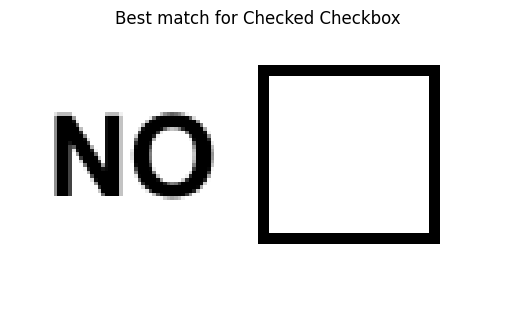

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (136, 68)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.05840807035565376
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (136, 68)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.07064398378133774
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (136, 71)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.03280296549201012
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (136, 72)
DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 136x72
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04326044023036957
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (136, 70)
DEBUG:

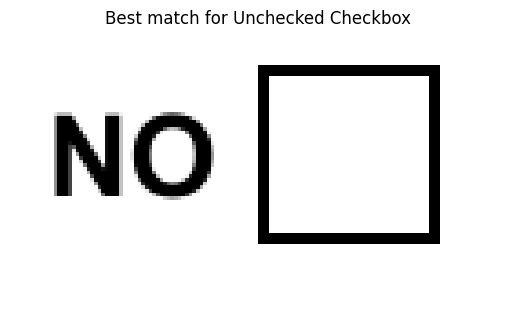

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (96, 36) and radius 21


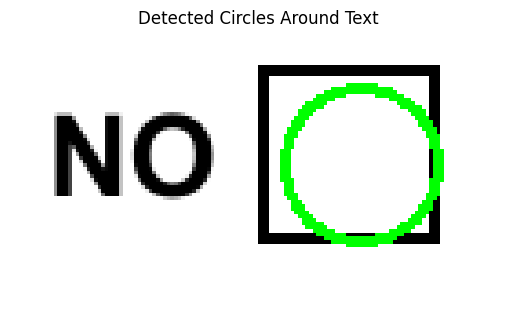

DEBUG:main:Image size: 136x77
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 136x67
DEBUG:main:Lines detected in checkbox: 10
DEBUG:main:Lines 3 intersect at angle 90.00 degrees with lengths 50.00, 43.00
DEBUG:main:Lines 4 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 25 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines detected but no V or X shape formed.


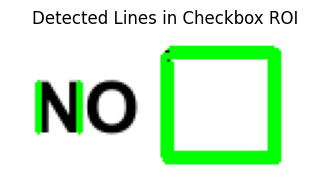

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'checkbox_unchecked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 59.78243947029114, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 62.38500475883484, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 100.0, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_69_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_82.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (129, 67)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x67
DEBUG:main:Template 'template_yes.PNG' match value: -0.06602798402309418
DEBUG:main:Resized template 'templa

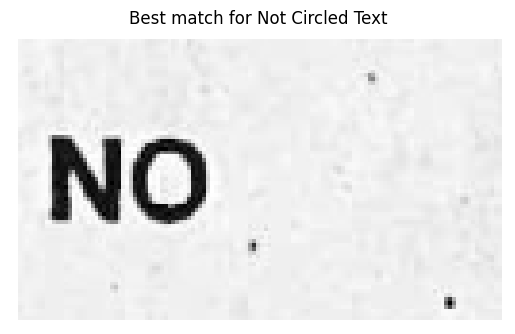

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (129, 64)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.06764370948076248
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (129, 64)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.15747632086277008
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (129, 64)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.06791949272155762
DEBUG:main:Resized template 'template_yes_check.PNG' to (129, 65)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07662776857614517
DEBUG:main:Resized template 'template_no_check.PNG' to (129, 72)
DEBUG:main:Image size: 129x76
D

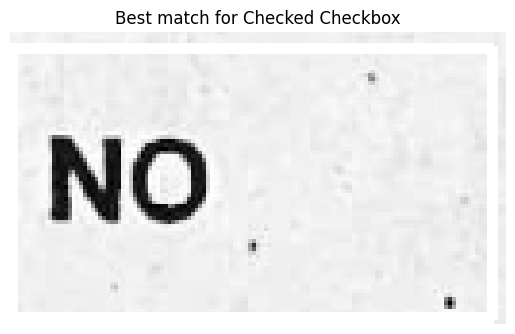

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (129, 64)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.03318610042333603
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (129, 65)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x65
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.03962516039609909
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (129, 68)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.03678416088223457
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (129, 68)
DEBUG:main:Image size: 129x76
DEBUG:main:Template size before resizing: 129x68
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.002012755023315549
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (129, 66)
DEBUG:m

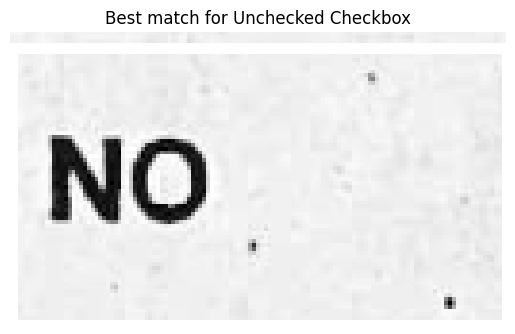

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 99.9998927116394, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 99.9998927116394, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 55.27525544166565, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 47.419315576553345, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_82_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_96.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (135, 70)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x70
DEBUG:main:Template 'template_yes.PNG' match val

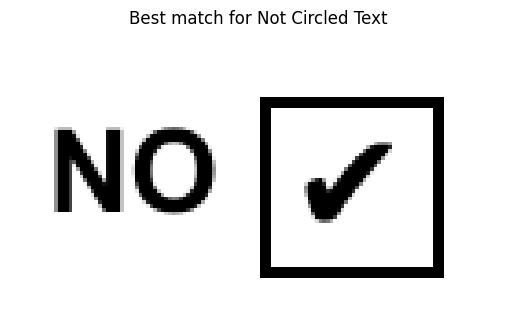

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.05597911402583122
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.12873029708862305
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.07352101802825928
DEBUG:main:Resized template 'template_yes_check.PNG' to (135, 68)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.05651072785258293
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Templa

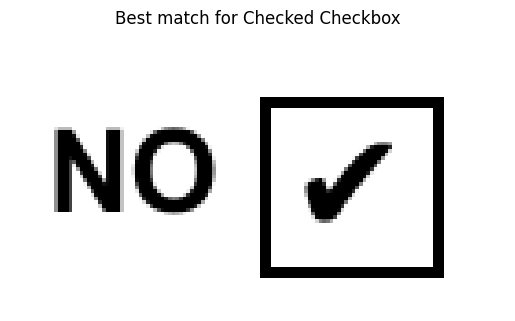

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (135, 67)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x67
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.00395378191024065
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (135, 68)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x68
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.017738102003932
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (135, 71)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.013808508403599262
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (135, 71)
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 135x71
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.00033343484392389655
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (135, 69)
DEBUG:m

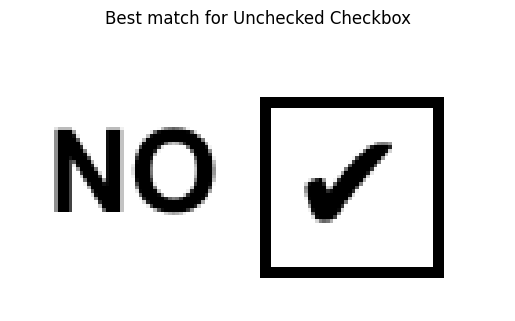

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 135x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 135x67
DEBUG:main:Lines detected in checkbox: 12
DEBUG:main:Lines 23 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 31 intersect at angle 90.00 degrees with lengths 50.00, 47.00
DEBUG:main:Lines 32 intersect at angle 90.00 degrees with lengths 50.00, 43.00
DEBUG:main:Lines 65 intersect at angle 81.87 degrees with lengths 21.21, 21.00
DEBUG:main:Lines detected but no V or X shape formed.


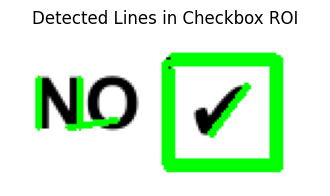

INFO:main:{'confidence': 99.99995231628418, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 50.391530990600586, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99995231628418, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 44.275081157684326, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_96_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_86.PNG
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 150x78
DEBUG:main:Template 'template_yes.PNG' match value: 0.3013867735862732
DEBUG:main:Resized template 'template_yes_2.PNG' to (552, 276)
DEBUG:ma

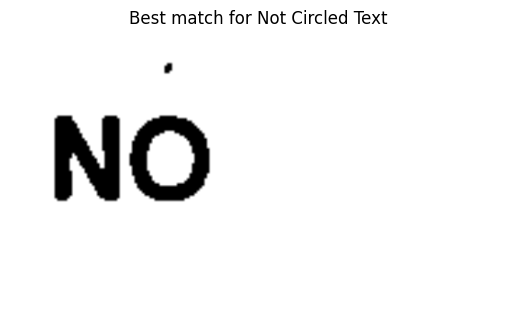

DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.2700614631175995
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.26438042521476746
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.2743494510650635
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 155x79
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.2717653810977936
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.21277624368667603
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.27332332730293274
DEBUG:main:Image size: 552x312
DEBUG:main:Templat

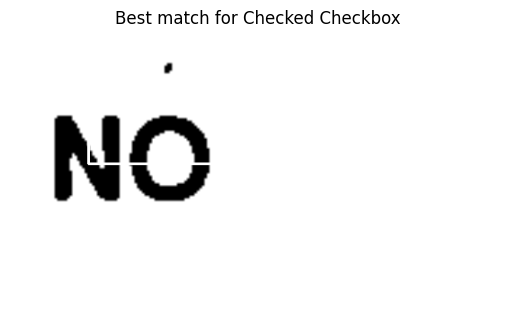

DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.24378535151481628
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 319x161
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.21111467480659485
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.24523402750492096
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 147x78
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.28320297598838806
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 151x78
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.2692432999610901
DEBUG:main:Image size: 552x312
DEBUG:main:Template size before resizing: 136x77
DEBUG:main:Template 'template_no_uncheck.PNG' match value: 0.2750469446182251
DEBUG:main:Image size: 552x312
DEB

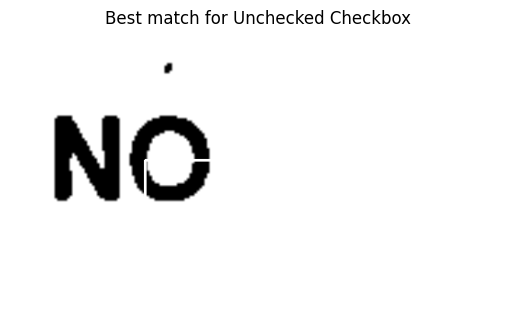

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (177, 137) and radius 44


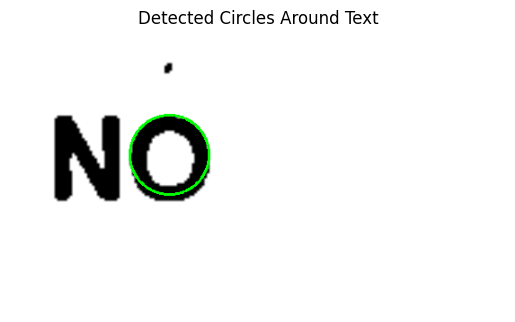

INFO:main:{'confidence': 100.0, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 100.0, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 33.13627541065216, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 33.22887122631073, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_86_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_76.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (142, 73)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x73
DEBUG:main:Template 'template_yes.PNG' match value: 0.5840906500816345
DEBUG:main:Resized template 'template_yes_2

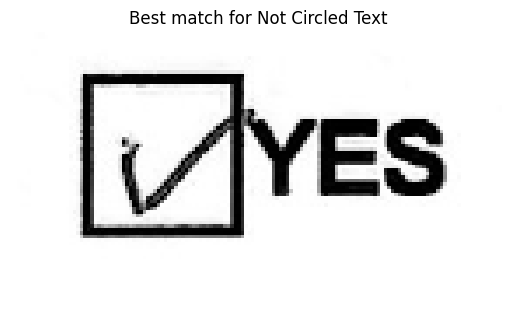

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (142, 70)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x70
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.5823118686676025
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (142, 71)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x71
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.3793626129627228
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (142, 70)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x70
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.45120394229888916
DEBUG:main:Resized template 'template_yes_check.PNG' to (142, 72)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x72
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.5776402950286865
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 

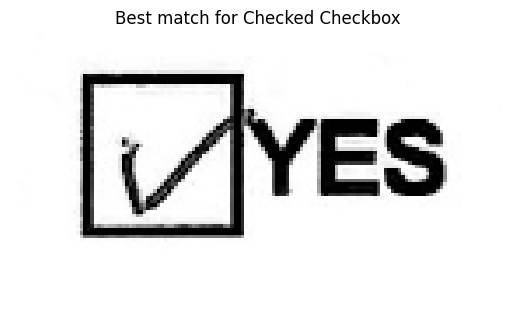

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (142, 71)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x71
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.7182080149650574
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (142, 71)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x71
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.4199947118759155
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (142, 74)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x74
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.7579203248023987
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (142, 75)
DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 142x75
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.8542302250862122
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (142, 73)
DEBUG:main:Ima

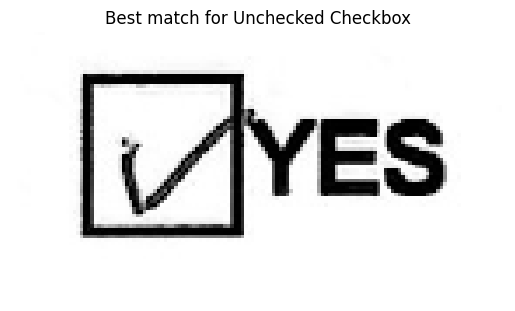

DEBUG:main:Circles detected: 2
DEBUG:main:Circles detected with centre at (54, 37) and radius 23
DEBUG:main:Circles detected with centre at (99, 71) and radius 42


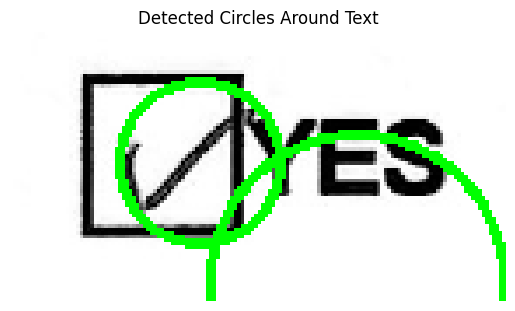

DEBUG:main:Image size: 142x77
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Resized template size: 142x71
DEBUG:main:Lines detected in checkbox: 17
DEBUG:main:Lines 9 intersect at angle 21.63 degrees with lengths 45.40, 12.37
DEBUG:main:V shape detected with confidence 100.00


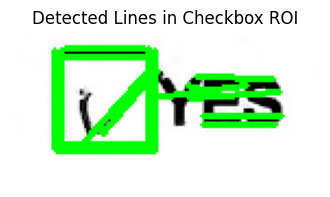

INFO:main:{'confidence': 100, 'final_result': True, 'test_performed': 'tick_marks', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.40906500816345, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 58.231186866760254, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 85.42302250862122, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 100, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_76_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no5.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (131, 68)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x68
DEBUG:main:Template 'template_yes.PNG' match value: -0.06132082641124725
DEBUG:main:Resized template 'temp

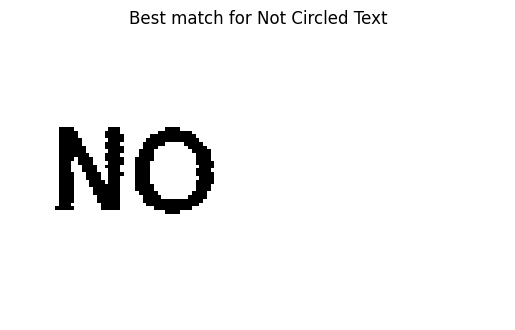

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.07006853818893433
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.17117184400558472
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.07622191309928894
DEBUG:main:Resized template 'template_yes_check.PNG' to (131, 66)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x66
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.06817670911550522
DEBUG:main:Resized template 'template_no_check.PNG' to (131, 73)
DEBUG:main:Image size: 131x76
D

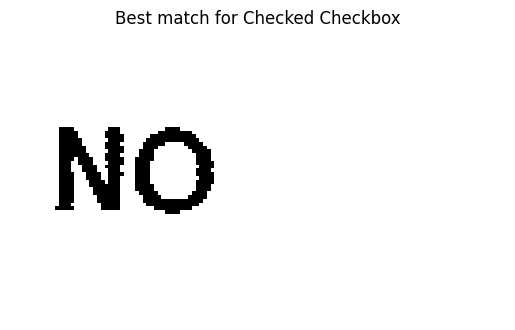

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.04256730526685715
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (131, 66)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.02258172817528248
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (131, 69)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.0508296899497509
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (131, 69)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x69
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04622412472963333
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (131, 67)
DEBUG:m

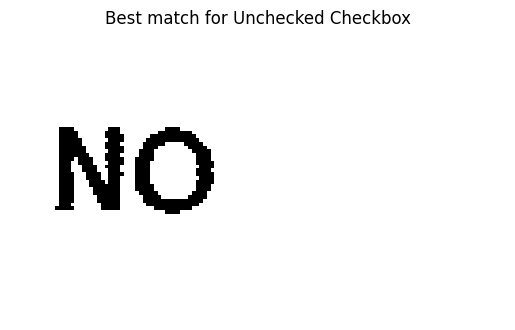

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 92.4963891506195, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 92.4963891506195, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 56.68862462043762, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 59.67188477516174, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no5_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no4.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (133, 69)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x69
DEBUG:main:Template 'template_yes.PNG' match value: -0.

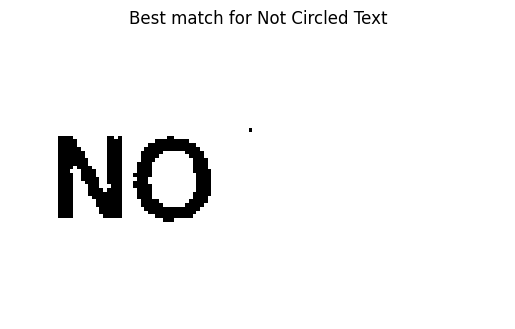

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.06751544773578644
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.15704050660133362
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.07373866438865662
DEBUG:main:Resized template 'template_yes_check.PNG' to (133, 67)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07184271514415741
DEBUG:main:Resized template 'template_no_check.PNG' to (133, 74)
DEBUG:main:Image size: 133x77
D

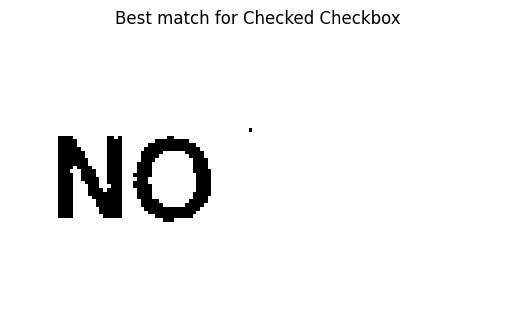

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (133, 66)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.02788095735013485
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (133, 67)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x67
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.049741946160793304
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (133, 70)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x70
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.043985817581415176
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (133, 70)
DEBUG:main:Image size: 133x77
DEBUG:main:Template size before resizing: 133x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.005700873676687479
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (133, 68)
DEBUG

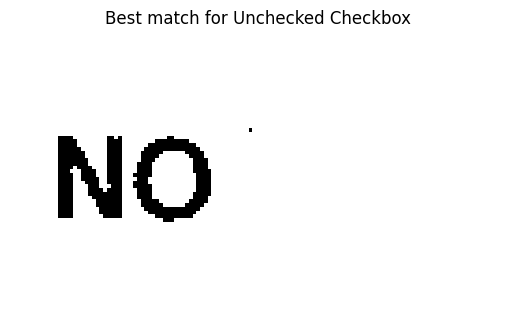

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 91.33692383766174, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 91.33692383766174, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 56.793367862701416, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 48.60694706439972, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no4_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_77.PNG
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 150x78
DEBUG:main:Template 'template_yes.PNG' match value: 0.6128472685813904
DEBUG:main:Resized template 'template

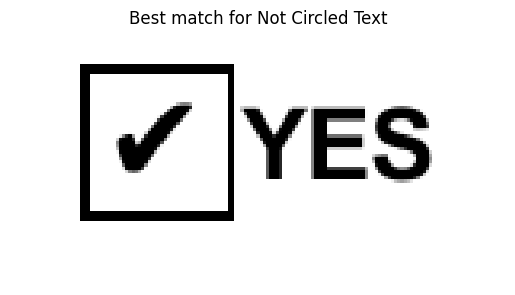

DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.9999992251396179
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.4447122812271118
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 155x77
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.859383761882782
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 155x79
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.9999986886978149
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.12470486760139465
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 125x70
DEBUG:main:Template 'template_no_check_2.PNG' match value: 0.14410088956356049
DEBUG:main:Image size: 155x79
DEBUG:main:Template size be

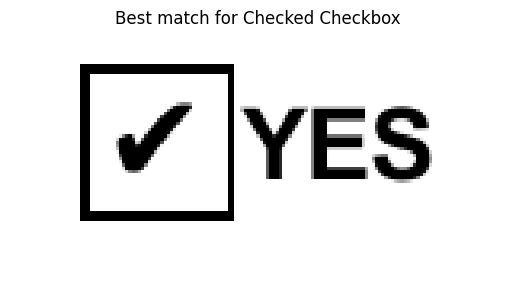

DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.9217483401298523
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (155, 78)
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 155x78
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.6577580571174622
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 146x77
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.5429796576499939
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 147x78
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.6885024309158325
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 151x78
DEBUG:main:Template 'template_yes_uncheck_5.PNG' match value: 0.38304609060287476
DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 136x77
DEBUG:main:Template 'template_no_uncheck.PNG' match 

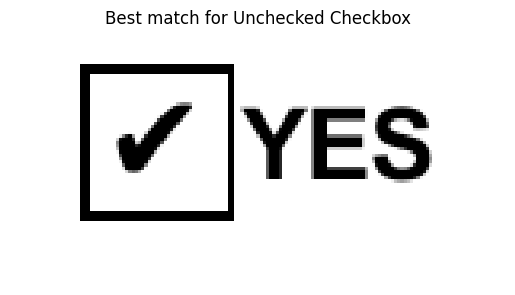

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 28


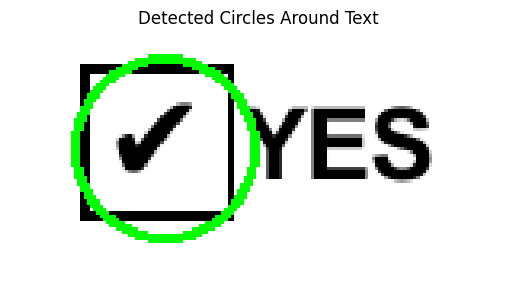

DEBUG:main:Image size: 155x79
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 15
DEBUG:main:Lines 5 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 8 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 18 intersect at angle 90.91 degrees with lengths 63.01, 43.00
DEBUG:main:Lines 22 intersect at angle 90.91 degrees with lengths 63.01, 41.00
DEBUG:main:Lines 60 intersect at angle 94.67 degrees with lengths 49.16, 43.00
DEBUG:main:Lines 64 intersect at angle 94.67 degrees with lengths 49.16, 41.00
DEBUG:main:Lines detected but no V or X shape formed.


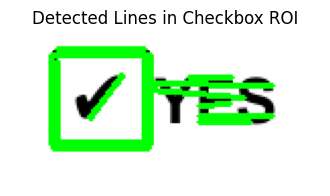

INFO:main:{'confidence': 99.99992251396179, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 61.28472685813904, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99992251396179, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 92.17483401298523, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_77_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_93.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (132, 68)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x68
DEBUG:main:Template 'template_yes.PNG' match value: 0.08943415433168411
DEBUG:main:Res

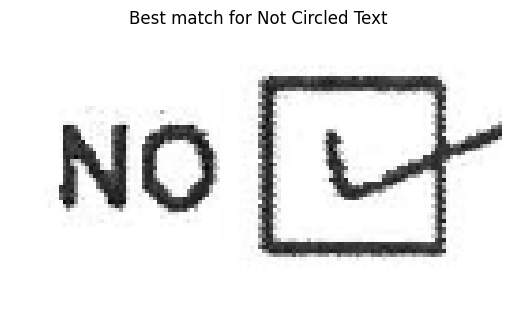

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.08103875070810318
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.10883104056119919
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (132, 65)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.08368899673223495
DEBUG:main:Resized template 'template_yes_check.PNG' to (132, 67)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x67
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.07935497909784317
DEBUG:main:Resized template 'template_no_check.PNG' to (132, 74)
DEBUG:main:Image size: 132x76
D

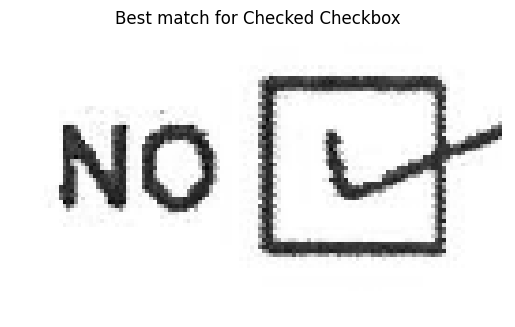

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.01309930719435215
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (132, 66)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.02559044398367405
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (132, 69)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.048872001469135284
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (132, 70)
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 132x70
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.034304432570934296
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (132, 68)
DEBUG:ma

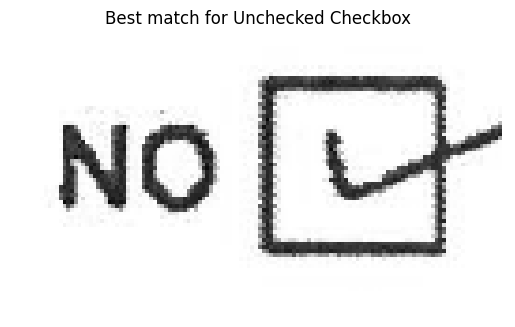

DEBUG:main:No circles detected around text.
DEBUG:main:Image size: 132x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Resized template size: 132x65
DEBUG:main:Lines detected in checkbox: 16
DEBUG:main:Lines 31 intersect at angle 66.64 degrees with lengths 46.00, 47.93
DEBUG:main:Lines 66 intersect at angle 31.49 degrees with lengths 47.93, 14.14
DEBUG:main:V shape detected with confidence 96.80


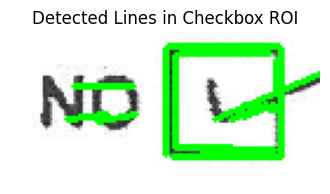

INFO:main:{'confidence': 99.99987483024597, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 46.21349275112152, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99987483024597, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 79.03595566749573, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': True, 'confidence': 96.79860403401992, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_93_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_91.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (128, 66)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x66
DEBUG:main:Template 'template_yes.PNG' match value: -0.06107374653220177

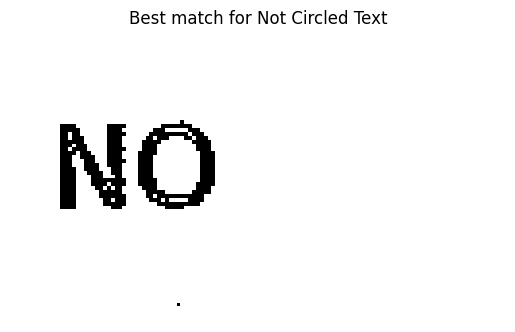

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (128, 63)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x63
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.06514431536197662
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.16703662276268005
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (128, 63)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x63
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.07262512296438217
DEBUG:main:Resized template 'template_yes_check.PNG' to (128, 65)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x65
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.061603717505931854
DEBUG:main:Resized template 'template_no_check.PNG' to (128, 72)
DEBUG:main:Image size: 128x75


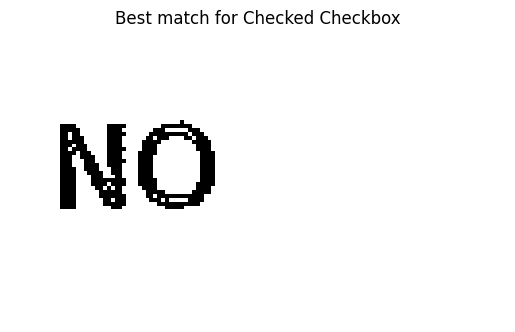

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: -0.050754364579916
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (128, 64)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x64
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: -0.021300721913576126
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (128, 67)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x67
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.05054023489356041
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (128, 67)
DEBUG:main:Image size: 128x75
DEBUG:main:Template size before resizing: 128x67
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: -0.04675009474158287
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (128, 66)
DEBUG:m

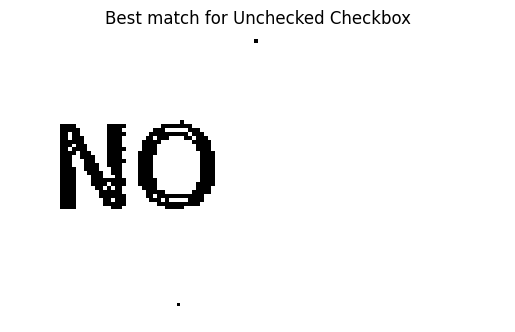

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 86.09261512756348, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 86.09261512756348, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 53.017204999923706, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 59.752899408340454, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_91_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no6.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (131, 68)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x68
DEBUG:main:Template 'template_yes.PNG' match val

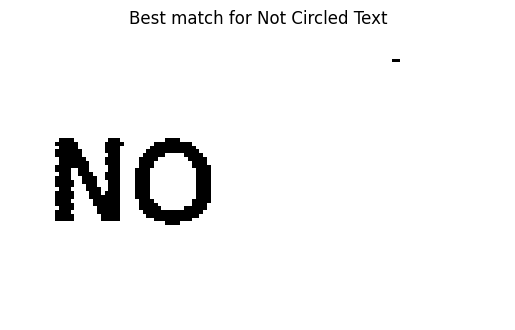

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.06111389026045799
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.15308457612991333
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.06753291934728622
DEBUG:main:Resized template 'template_yes_check.PNG' to (131, 66)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x66
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.06879798322916031
DEBUG:main:Resized template 'template_no_check.PNG' to (131, 73)
DEBUG:main:Image size: 131x76
D

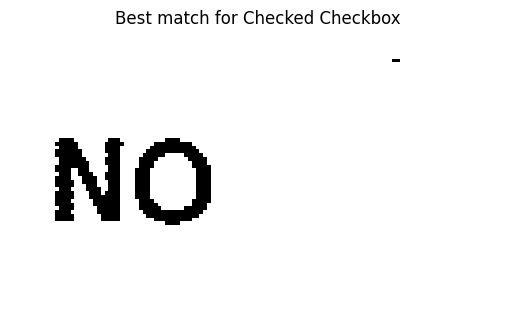

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (131, 65)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x65
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.04542822018265724
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (131, 66)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x66
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.06321554630994797
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (131, 69)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x69
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.025552112609148026
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (131, 69)
DEBUG:main:Image size: 131x76
DEBUG:main:Template size before resizing: 131x69
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.013723653741180897
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (131, 67)
DEBUG:m

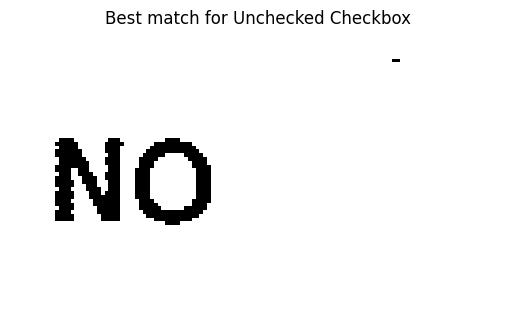

DEBUG:main:No circles detected around text.
INFO:main:{'confidence': 99.99989867210388, 'final_result': True, 'test_performed': 'not_circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 99.99989867210388, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 57.05784559249878, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 40.78492820262909, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': False, 'confidence': 0, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no6_annotated.png
INFO:main:

 processing image 	 dataset/images_test/no1_8.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (126, 65)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x65
DEBUG:main:Template 'template_yes.PNG' match value:

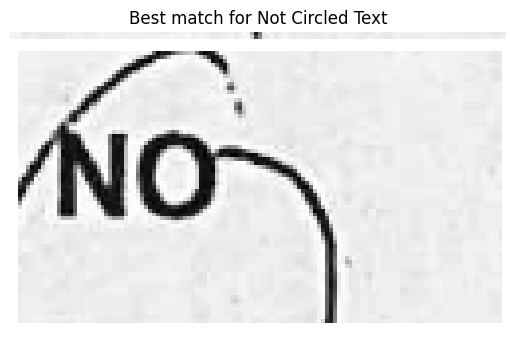

DEBUG:main:Resized template 'template_yes_check_4.PNG' to (126, 62)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x62
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.08301255851984024
DEBUG:main:Resized template 'template_yes_check_2.PNG' to (126, 63)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.17776302993297577
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (126, 62)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x62
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.0976644903421402
DEBUG:main:Resized template 'template_yes_check.PNG' to (126, 64)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x64
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.0791667103767395
DEBUG:main:Resized template 'template_no_check.PNG' to (126, 70)
DEBUG:main:Image size: 126x75
DEB

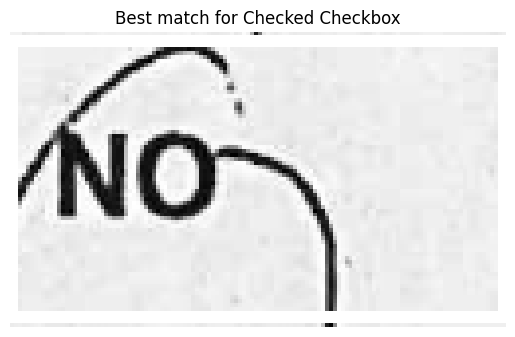

DEBUG:main:Resized template 'template_yes_uncheck.PNG' to (126, 63)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.023378072306513786
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (126, 63)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x63
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.061526160687208176
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (126, 66)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x66
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: -0.025285229086875916
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (126, 66)
DEBUG:main:Image size: 126x75
DEBUG:main:Template size before resizing: 126x66
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.005155496299266815
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (126, 65)
DEBUG

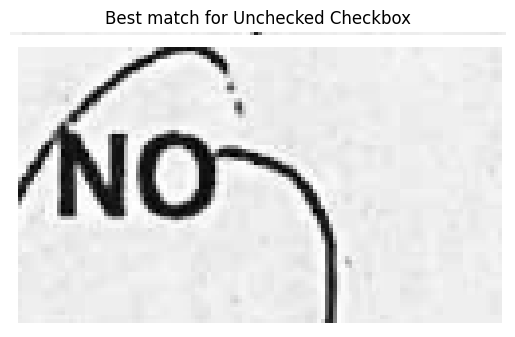

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (43, 60) and radius 35


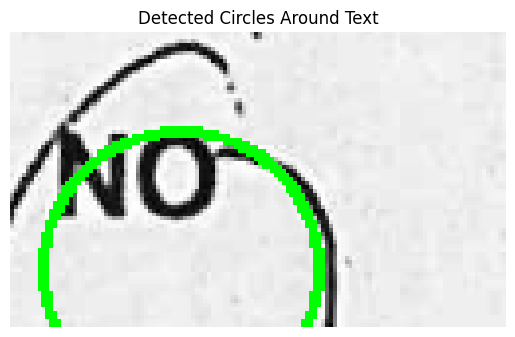

INFO:main:{'confidence': 80, 'final_result': True, 'test_performed': 'circled', 'all_attempts': {'not_circled': {'detected': True, 'confidence': 70.86110711097717, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': False, 'confidence': 50.20712614059448, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': False, 'confidence': 49.06386435031891, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 0, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/no1_8_annotated.png
INFO:main:

 processing image 	 dataset/images_test/yes1_60.PNG
DEBUG:main:Resized template 'template_yes.PNG' to (146, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 146x76
DEBUG:main:Template 'template_yes.PNG' match value: 0.5834232568740845
DEBUG:main:Resized template 'template_y

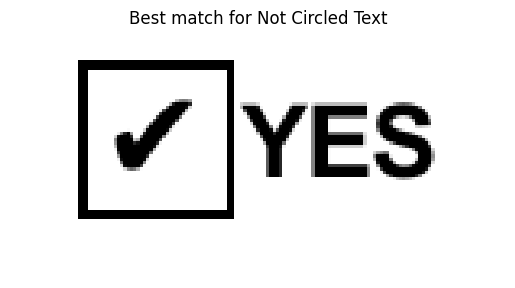

DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Template 'template_yes_check_4.PNG' match value: 0.9999983310699463
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 150x75
DEBUG:main:Template 'template_yes_check_2.PNG' match value: 0.44471320509910583
DEBUG:main:Resized template 'template_yes_check_3.PNG' to (152, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_check_3.PNG' match value: 0.911383867263794
DEBUG:main:Resized template 'template_yes_check.PNG' to (149, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 149x76
DEBUG:main:Template 'template_yes_check.PNG' match value: 0.779890775680542
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 135x76
DEBUG:main:Template 'template_no_check.PNG' match value: 0.11215391755104065
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 125x70
DE

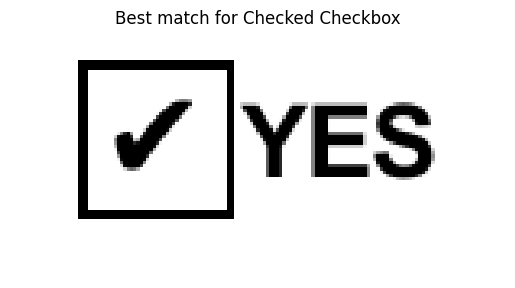

DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 152x76
DEBUG:main:Template 'template_yes_uncheck.PNG' match value: 0.9217483401298523
DEBUG:main:Resized template 'template_yes_uncheck_2.PNG' to (150, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 150x76
DEBUG:main:Template 'template_yes_uncheck_2.PNG' match value: 0.7633844614028931
DEBUG:main:Resized template 'template_yes_uncheck_3.PNG' to (144, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 144x76
DEBUG:main:Template 'template_yes_uncheck_3.PNG' match value: 0.44329652190208435
DEBUG:main:Resized template 'template_yes_uncheck_4.PNG' to (143, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 143x76
DEBUG:main:Template 'template_yes_uncheck_4.PNG' match value: 0.5519600510597229
DEBUG:main:Resized template 'template_yes_uncheck_5.PNG' to (147, 76)
DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 147x76
DE

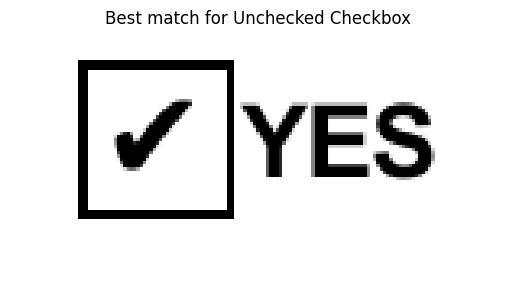

DEBUG:main:Circles detected: 1
DEBUG:main:Circles detected with centre at (48, 36) and radius 29


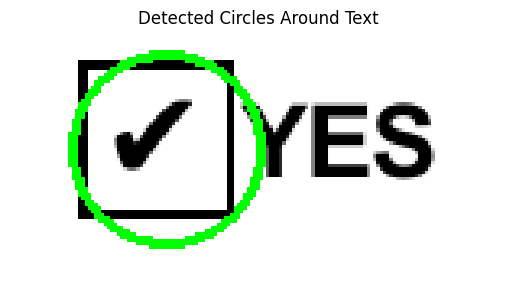

DEBUG:main:Image size: 153x76
DEBUG:main:Template size before resizing: 153x76
DEBUG:main:Lines detected in checkbox: 15
DEBUG:main:Lines 5 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 8 intersect at angle 90.00 degrees with lengths 49.00, 43.00
DEBUG:main:Lines 18 intersect at angle 90.91 degrees with lengths 63.01, 43.00
DEBUG:main:Lines 22 intersect at angle 90.91 degrees with lengths 63.01, 41.00
DEBUG:main:Lines 60 intersect at angle 94.67 degrees with lengths 49.16, 43.00
DEBUG:main:Lines 64 intersect at angle 94.67 degrees with lengths 49.16, 41.00
DEBUG:main:Lines detected but no V or X shape formed.


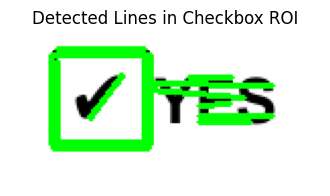

INFO:main:{'confidence': 99.99983310699463, 'final_result': True, 'test_performed': 'checkbox_checked', 'all_attempts': {'not_circled': {'detected': False, 'confidence': 58.34232568740845, 'test': 'Text not circled using templates'}, 'checkbox_checked': {'detected': True, 'confidence': 99.99983310699463, 'test': 'Checkbox checked using templates'}, 'checkbox_unchecked': {'detected': True, 'confidence': 92.17483401298523, 'test': 'Checkbox unchecked using templates'}, 'circled': {'detected': True, 'confidence': 80, 'test': 'Text circled detection'}, 'tick_marks': {'detected': False, 'confidence': 50, 'test': 'Tick marks in checkbox area'}}}
INFO:main:Annotated image saved to results/yes1_60_annotated.png


In [32]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder = "dataset/images_test"


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold


 
image_paths = list_files_in_folder(folder,ext="PNG")

print(folder)
for file_name in image_paths:
    full_file_path = os.path.join(folder, file_name)

    filename = full_file_path.split("/")[-1]
    name = filename.split(".")[0]
    unique_strings = [
    # "no1_93",
    # "no1_86",
    # "yes1_2",
    # "no1_96",
    # "no1_97",
    # "yes1_79",
    # "no1_27",
    # "no1_2",
    # "no4",
    # "no1_71",
    # "yes1_60",
    "no1_22"
]

    # if name  in unique_strings:
    if name  in unique_strings or 1:
    # break   

        result_payload = process_image(full_file_path, threshold=threshold, show_plots=True)
        LOGGER.info(result_payload)



        # Save the resulting images with green or red text
        output_directory = 'results'
        file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
        image = cv2.imread(full_file_path)
        annotated_image_path = annotate_image(
            image=image,
            result_payload=result_payload,
            output_path=output_directory,
            file_name_prefix=file_name_prefix,
        )

        

In [ ]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [ ]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)